MASSACHUSETTS INSTITUTE OF TECHNOLOGY<br>
SYSTEM DESIGN & MANAGEMENT<br>
Author: R. Chadwick Holmes<br>
Date: April 10, 2021<br>
Last Updated: December 9, 2021<br><br>

**Label: Final Workflow, Script 4**<br>
**Lowest Number of Features (based on Shapley)**<br>

Script Purpose:<br>
Script for exploring supervised learning applied to the data set and the impact of uncertainties.
<br><br>


In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, 
and then re-execute this cell.


In [ ]:
!apt update
!apt upgrade
!apt install gdal-bin python-gdal python3-gdal 
# Install rtree - Geopandas requirment
!apt install python3-rtree 
# Install Geopandas
!pip install git+git://github.com/geopandas/geopandas.git
# Install descartes - Geopandas requirment
!pip install descartes cartopy
!pip uninstall -y shapely
!pip install shapely --no-binary shapely
!pip install dataprep --no-binary dataprep
!pip install shap --no-binary shap

Hit:1 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:2 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:3 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:4 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:5 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:6 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:7 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Hit:8 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease
Get:9 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:11 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:12 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:13 https://developer.download

In [ ]:
from sklearn.linear_model import LinearRegression, LogisticRegression, LassoCV, Lasso
from sklearn.model_selection import GridSearchCV, cross_val_score, RepeatedKFold, RepeatedStratifiedKFold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler, RobustScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn import tree

from collections import Counter

import statsmodels.api as sm
from scipy import stats

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

from pathlib import Path
import pickle as pkl

import geopandas as gpd  # combines the capabilities of pandas and shapely for geospatial operations
from shapely.geometry import Point, Polygon, MultiPolygon  # for manipulating text data into geospatial shapes
from shapely import wkt  # stands for "well known text," allows for interchange across GIS programs
import rtree  # supports geospatial join

import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap

import seaborn as sns

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.io.img_tiles as cimgt
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Set seed for randomized elements in script

In [ ]:
seed = 43

# define extent for mapping
xmin,xmax,ymin,ymax = [-109.1, -105.9, 31.3, 35.4]
extent = [xmin,xmax,ymin,ymax]

### Mount Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
path = r'/content/drive/MyDrive/Colab Notebooks/Data'

Mounted at /content/drive


### Load data from saved pickle file

In [24]:
datafolder = Path(path) 

#with open(datafolder/ "wells_shared.pkl","rb") as handle:
#with open(datafolder/ "wellsp4_shared.pkl","rb") as handle:
with open(datafolder/ "wellsp8_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
fulldf = datadict['data']
coords = datadict['coords']
X_train = datadict['X_train'].reset_index(drop=True)
X_val   = datadict['X_val'].reset_index(drop=True)
X_test  = datadict['X_test'].reset_index(drop=True)
yr_train = datadict['yr_train'].reset_index(drop=True)
yr_val   = datadict['yr_val'].reset_index(drop=True)
yr_test  = datadict['yr_test'].reset_index(drop=True)
yc_train = datadict['yc_train'].reset_index(drop=True)
yc_val   = datadict['yc_val'].reset_index(drop=True)
yc_test  = datadict['yc_test'].reset_index(drop=True)

In [25]:
print(X_train.shape)
X_train.head(2)

(3740, 26)


,DEM,DEMGrad,Gravity,GravityGrad,Magnetic,MagneticGrad,DosageRate,WTDepth,WTGrad,BasementDepth,CrustalThickness,AirTemperature,Precipitation,StrainRate,QFaults,StateFaults,Drainage,VolcanicDikes,SiGeothermometry,Lithium,Boron,HeatFlow,Earthquakes,Vents,Springs,GeothermGrad_2class
0,1186.0,0.000721,-161.180160,0.108319,-107.463425,0.561295,60.852009,22.27627,99243.062500,3698.876465,27.677557,17.012707,252.241196,1.210380,6.670007,7.919702,6.763772,0.002239,48.957527,0.118951,0.157249,119.273399,-25.697401,-25.798687,-26.834686,"[60, 9999)"
1,1254.0,0.003242,-160.070038,0.038074,-7.054341,0.933958,42.791359,329.38385,52782.089844,5233.645996,27.727911,17.137991,248.240890,0.559776,4.711527,2.943224,2.315694,0.000000,49.298653,0.159062,0.336346,97.183159,-26.302048,-25.682467,-28.121691,"[0, 60)"


In [26]:
myprojection = ccrs.PlateCarree()

def createBasemap():
    expl_area = datafolder / 'Exploration_area.shp'
    expl_area_feat = ShapelyFeature(Reader(expl_area).geometries(), crs=myprojection, edgecolor='black')

    rivers_50m = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m')
    #stamen_terrain = cimgt.Stamen('terrain-background')

    # generate plot of NM with river and stock image
    plt.figure(figsize=(20,12))
    ax = plt.axes(projection=myprojection)

    # Add the Stamen data at zoom level 9.
    ax.stock_img()
    #ax.add_image(stamen_terrain, 9)
    
    ax.add_feature(cartopy.feature.STATES)
    ax.add_feature(rivers_50m, facecolor='None', edgecolor='b')
    ax.add_feature(expl_area_feat, facecolor='None', edgecolor='r', linewidth=2, alpha = 0.5)

    ax.set_extent(extent,crs=myprojection)
    
    return ax

## Test that plotting works

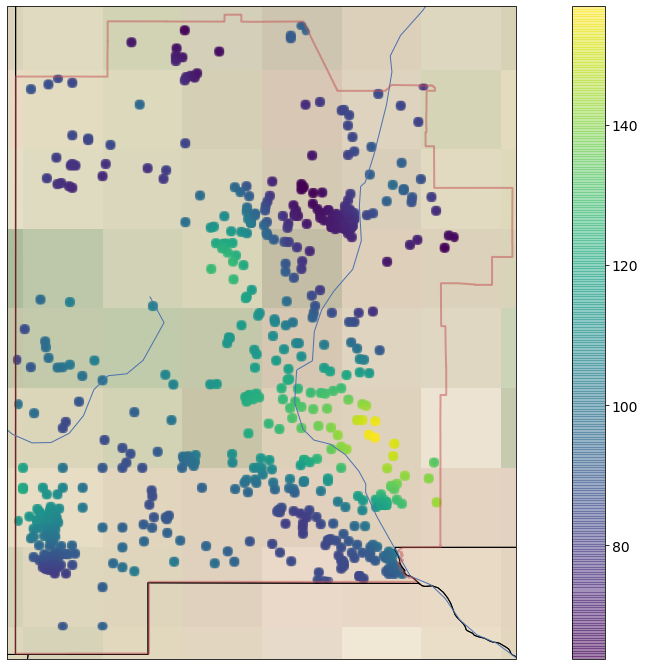

In [27]:
ax = createBasemap();

gdf = gpd.GeoDataFrame(fulldf.copy(deep=True), 
                       geometry=gpd.points_from_xy(coords.Longitude, coords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(coords.Longitude,
                coords.Latitude,
                cmap='viridis',
                c=gdf['HeatFlow'],
                #c=gdf['CutCategory'].cat.codes,
                #vmin=0, vmax=125,
                alpha=0.5,
                transform=myprojection);
plt.colorbar(pc);

### Data Prep

In [28]:
## Set Plotting Parameters
SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=BIGGER_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [29]:
list(X_train)

['DEM',
 'DEMGrad',
 'Gravity',
 'GravityGrad',
 'Magnetic',
 'MagneticGrad',
 'DosageRate',
 'WTDepth',
 'WTGrad',
 'BasementDepth',
 'CrustalThickness',
 'AirTemperature',
 'Precipitation',
 'StrainRate',
 'QFaults',
 'StateFaults',
 'Drainage',
 'VolcanicDikes',
 'SiGeothermometry',
 'Lithium',
 'Boron',
 'HeatFlow',
 'Earthquakes',
 'Vents',
 'Springs',
 'GeothermGrad_2class']

In [30]:
rfe_cols = ['Gravity', 'Magnetic', 'RadiationDosage', 'StrainRate', 'QFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry', 'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs']
# drop columns already determined to be colinear or are predicted variables
dropcols = ['AirTemperature','GeothermGrad_2class']
#dropcols = [x for x in X_train.columns if x not in rfe_cols]
print(dropcols)
Xtr = X_train.drop(dropcols,axis=1)
Xvl = X_val.drop(dropcols,axis=1)
Xts = X_test.drop(dropcols,axis=1)

# 4-class model 
yc_test4  = yc_test['GeothermGrad_4class'].cat.codes
yc_val4   = yc_val['GeothermGrad_4class'].cat.codes
yc_train4 = yc_train['GeothermGrad_4class'].cat.codes

# encode classification variable
le = LabelEncoder()
le.fit(yc_train4)
yenc_trn = le.transform(yc_train4)
yenc_val = le.transform(yc_val4)
yenc_tst = le.transform(yc_test4)

['AirTemperature', 'GeothermGrad_2class']


In [31]:
# template for scaling and transforming data

# scale and transform data
sc = StandardScaler()
pt = PowerTransformer(method='yeo-johnson',standardize=True)
pl = Pipeline(steps=[('scale',sc),('powertransform',pt)])

colnames = list(Xtr.columns)
pl.fit(Xtr,yr_train)
Xtrsc = pd.DataFrame(pl.transform(Xtr), columns=colnames)
Xvlsc = pd.DataFrame(pl.transform(Xvl), columns=colnames)
Xtssc = pd.DataFrame(pl.transform(Xts), columns=colnames)

In [32]:
print('train:')
counter = Counter(yc_train4)
for k,v in counter.items():
	per = v / len(yc_train4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
 
print('\nvalidate:')
counter = Counter(yc_val4)
for k,v in counter.items():
	per = v / len(yc_val4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

print('\ntest:')
counter = Counter(yc_test4)
for k,v in counter.items():
	per = v / len(yc_test4) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
print()
print(list(Xtr))

train:
Class=3, n=1558 (41.658%)
Class=2, n=1420 (37.968%)
Class=0, n=129 (3.449%)
Class=1, n=633 (16.925%)

validate:
Class=0, n=27 (3.367%)
Class=2, n=305 (38.030%)
Class=1, n=136 (16.958%)
Class=3, n=334 (41.646%)

test:
Class=2, n=304 (37.905%)
Class=1, n=136 (16.958%)
Class=3, n=334 (41.646%)
Class=0, n=28 (3.491%)

['DEM', 'DEMGrad', 'Gravity', 'GravityGrad', 'Magnetic', 'MagneticGrad', 'DosageRate', 'WTDepth', 'WTGrad', 'BasementDepth', 'CrustalThickness', 'Precipitation', 'StrainRate', 'QFaults', 'StateFaults', 'Drainage', 'VolcanicDikes', 'SiGeothermometry', 'Lithium', 'Boron', 'HeatFlow', 'Earthquakes', 'Vents', 'Springs']


### XGBoosting Time!
####https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

https://towardsdatascience.com/xgboost-for-multi-class-classification-799d96bcd368

In [83]:
import shap
import xgboost as xgb
print(xgb.__version__)
from xgboost.sklearn import XGBClassifier
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

## adapted from
## https://github.com/ernestng11/touchpoint-prediction/blob/master/model-building.ipynb

# plot logloss and classification error after each iteration
def plot_compare(mets, eval_results, epochs):
  #print(eval_results)
  for m in mets:
    val_score = eval_results['val'][m]
    train_score = eval_results['train'][m]
    rang = range(0, epochs)
    plt.rcParams["figure.figsize"] = [6,6]
    plt.plot(rang, val_score,"c", label="Val")
    plt.plot(rang, train_score,"orange", label="Train")
    title_name = m + " plot"
    plt.title(title_name)
    plt.xlabel('Iterations')
    plt.ylabel(m)
    lgd = plt.legend()
    plt.show()

def XGBfit(model, 
           Xtrain, ytrain, 
           Xval, yval, 
           Xtest, ytest,
           predictors,
           savefig=False):

    xgb_param = model.get_xgb_params()
    mets = ['mlogloss','merror']
    xgb_param['eval_metric'] = mets
    xgb_param['num_class'] = len(np.unique(ytrain))
   
    xgtrain  = xgb.DMatrix(Xtrain[predictors].values, 
                           label=ytrain,
                           feature_names=predictors)
    xgval    = xgb.DMatrix(Xval[predictors].values,
                           label=yval,
                           feature_names=predictors)
    xgtest   = xgb.DMatrix(Xtest[predictors].values,
                           label=ytest,
                           feature_names=predictors)
    evallist = [(xgval, 'val'),(xgtrain, 'train')]

    store = {}
    xg_mod = xgb.train(xgb_param, xgtrain,
                       num_boost_round=model.get_params()['n_estimators'],
                       evals=evallist,
                       evals_result=store,
                       verbose_eval=100)       

    # predict
    predprobs = xg_mod.predict(xgtrain)
    preds     = np.argmax(predprobs, axis=1)
    predprobs_test = xg_mod.predict(xgtest)
    preds_test = np.argmax(predprobs_test, axis=1)

    # print stats
    print("\nXGBFit Results")
    print("Accuracy (Train) : %.4g" % metrics.accuracy_score(ytrain, preds))
    print("Accuracy (Test)  : %.4g" % metrics.accuracy_score(ytest, preds_test))
    print("F1-weighted (Train): %f" % metrics.f1_score(ytrain, preds, average='weighted'))
    print("F1-weighted (Test) : %f" % metrics.f1_score(ytest, preds_test,average='weighted'))
    print("macro AUC (Train): %f" % metrics.roc_auc_score(ytrain, predprobs, average='macro', multi_class='ovr'))
    print("weighted AUC (Train): %f" % metrics.roc_auc_score(ytrain, predprobs, average='weighted', multi_class='ovr'))
    print("macro AUC (Test) : %f" % metrics.roc_auc_score(ytest, predprobs_test, average='macro', multi_class='ovr'))
    print("weighted AUC (Test): %f" % metrics.roc_auc_score(ytest, predprobs_test, average='weighted', multi_class='ovr'))

    # print confusion matrix
    confusion = confusion_matrix(ytest, preds_test)
    print(confusion)
    print(classification_report(ytest, preds_test, 
                                target_names=['No-GT','Low-GT','Med-GT','High-GT']))

    with mpl.style.context('default'):
      df_cm = pd.DataFrame(confusion, range(4), range(4))
      sns.set(font_scale=1.4) # for label size
      sns.heatmap(df_cm, cmap='viridis',vmax=40,annot=True, 
                fmt='g', annot_kws={"size": 16}) # font size
      plt.xlabel('Predicted')
      ax = plt.gca()
      ax.xaxis.set_label_position('top') 
      plt.ylabel('Actual Class',labelpad=5)
      ax.xaxis.tick_top()
      ax.yaxis.tick_left()

      if(savefig):  
        plt.savefig(datafolder / 'XGBoost_WDS8_ConfusionMatrix.png', bbox_inches='tight')
      plt.show()

    # plot training plots
    plot_compare(mets, store, xgb_param['n_estimators'])

    # plot feature importances
    f, ax = plt.subplots(figsize=(10,5))

    fimport = pd.Series(xg_mod.get_fscore())
    fimport = fimport.sort_values(ascending=False)
    plot = sns.barplot(fimport.index,fimport.values)
    ax.set_title('Feature Importance')
    plot.set_xticklabels(plot.get_xticklabels(),rotation='vertical')
    plt.show()

    # move booster back into scikit XGBClassifier
    model._Booster = xg_mod

    xgb.plot_importance(model)
    
    return model

0.90


In [34]:
def getTrainScores(gs):
    results = {}
    runs = 0
    for x,y in zip(list(gs.cv_results_['mean_test_score']), gs.cv_results_['params']):
        results[runs] = 'mean:' + str(x) + 'params' + str(y)
        runs += 1
    best = {'best_mean': gs.best_score_, "best_param":gs.best_params_}
    return results, best

### Run without tuning

In [35]:
LR    = 0.01
NEST  = 200
MAXD  = 5
MINCW = 1
GAMMA = 0.2
SSBT, CSBT = 1., 1.
LAMBDA = 1.0
SPWT  = 1.0  # tune later: class imbalance

best_params = {}

In [36]:
print(Xtrsc.shape, yenc_trn.shape, Xvlsc.shape, yenc_val.shape, Xtssc.shape, yenc_tst.shape)

(3740, 24) (3740,) (802, 24) (802,) (802, 24) (802,)


[0]	val-mlogloss:1.37485	val-merror:0.188279	train-mlogloss:1.37415	train-merror:0.141176
[100]	val-mlogloss:0.72473	val-merror:0.120948	train-mlogloss:0.685147	train-merror:0.083155
[199]	val-mlogloss:0.482863	val-merror:0.097257	train-mlogloss:0.427074	train-merror:0.052674

XGBFit Results
Accuracy (Train) : 0.9473
Accuracy (Test)  : 0.9052
F1-weighted (Train): 0.947049
F1-weighted (Test) : 0.904500
macro AUC (Train): 0.993875
weighted AUC (Train): 0.992229
macro AUC (Test) : 0.985166
weighted AUC (Test): 0.981808
[[ 22   5   0   1]
 [  0 107  20   9]
 [  0   3 288  13]
 [  0   0  25 309]]
              precision    recall  f1-score   support

       No-GT       1.00      0.79      0.88        28
      Low-GT       0.93      0.79      0.85       136
      Med-GT       0.86      0.95      0.90       304
     High-GT       0.93      0.93      0.93       334

    accuracy                           0.91       802
   macro avg       0.93      0.86      0.89       802
weighted avg       0.

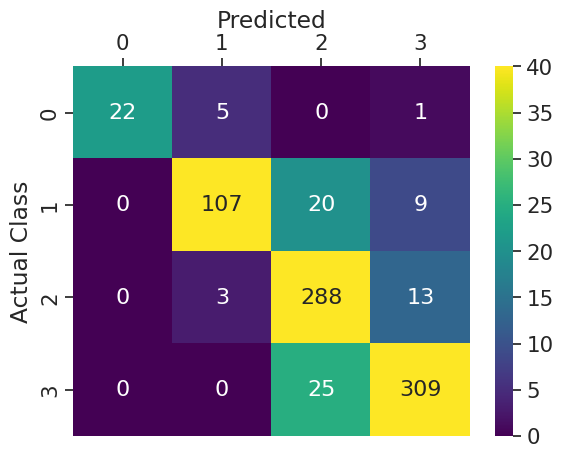

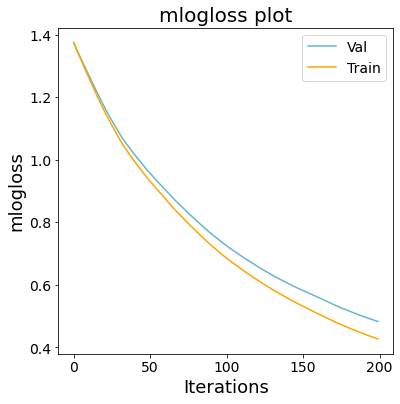

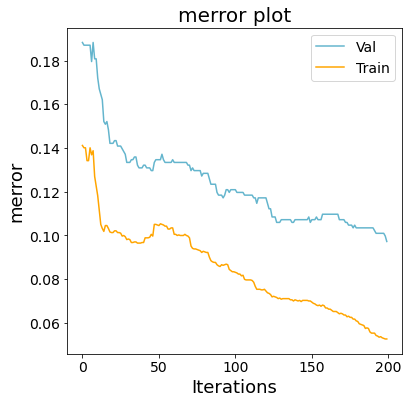

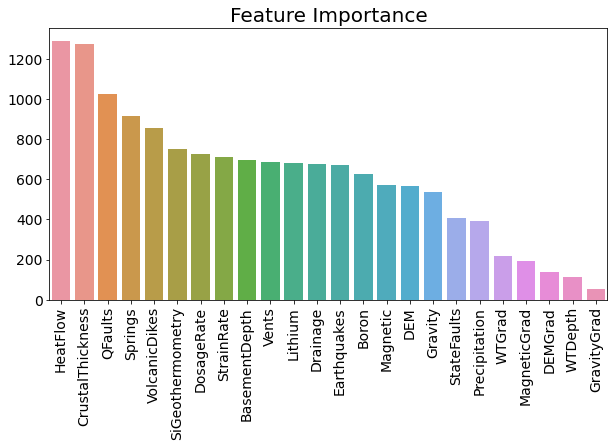

XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=5,
              n_estimators=200, n_jobs=-1, objective='multi:softprob',
              reg_lambda=1.0, scale_pos_weight=1.0, seed=43, subsample=1.0)


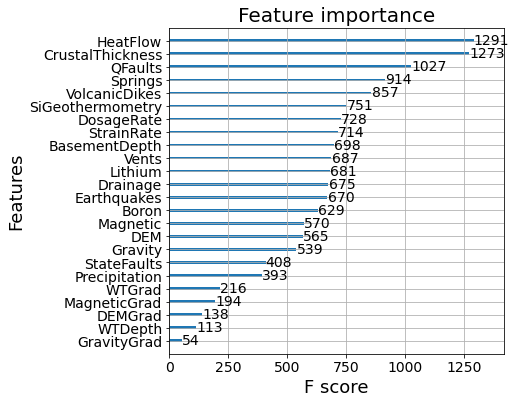

In [37]:
# First Run, Untuned 

#Choose all predictors except target & IDcols
keepcols = [x for x in Xtr.columns if x not in dropcols]
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

xgb_model = XGBfit(xgb_model, 
                   Xtrsc, pd.Series(yenc_trn,name='GeothermGrad'), 
                   Xvlsc, pd.Series(yenc_val,name='GeothermGrad'), 
                   Xtssc, pd.Series(yenc_tst,name='GeothermGrad'), 
                   keepcols);
print(xgb_model)

### Create combination train + validate set

In [38]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
import matplotlib as mpl

Xtrvl = pd.concat([Xtr[colnames],Xvl[colnames]])
Xtrnvalsc=pd.concat([Xtrsc[colnames],Xvlsc[colnames]])
yenc_trnval=np.append(yenc_trn,yenc_val)

### Tune on max_depth

In [40]:
# Tuning of max_depth

valrng = range(1,16,1)
params_gs1 = {
  'max_depth':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv1 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs1,
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose=10,
                       cv=cv)
gridcv1 = gridcv1.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['max_depth'] = gridcv1.best_params_['max_depth']
MAXD = best_params['max_depth']

getTrainScores(gridcv1)

Fitting 30 folds for each of 15 candidates, totalling 450 fits


({0: "mean:0.8329563840288675params{'max_depth': 1}",
  1: "mean:0.9181221373729063params{'max_depth': 2}",
  2: "mean:0.9577120162751982params{'max_depth': 3}",
  3: "mean:0.9752440142727378params{'max_depth': 4}",
  4: "mean:0.9834655594704952params{'max_depth': 5}",
  5: "mean:0.987840768873023params{'max_depth': 6}",
  6: "mean:0.9903265511942876params{'max_depth': 7}",
  7: "mean:0.9922300694452629params{'max_depth': 8}",
  8: "mean:0.9928205286130916params{'max_depth': 9}",
  9: "mean:0.9933806041091491params{'max_depth': 10}",
  10: "mean:0.9936657367963823params{'max_depth': 11}",
  11: "mean:0.9936467022432277params{'max_depth': 12}",
  12: "mean:0.9939378148698732params{'max_depth': 13}",
  13: "mean:0.9939702342407606params{'max_depth': 14}",
  14: "mean:0.9940732399546446params{'max_depth': 15}"},
 {'best_mean': 0.9940732399546446, 'best_param': {'max_depth': 15}})

#### plot for thesis figure

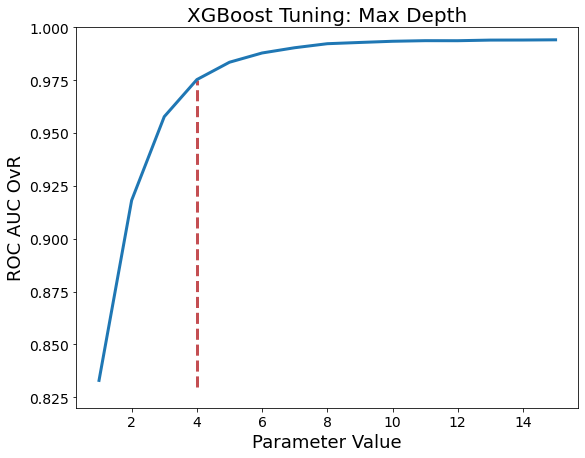

In [60]:
gridcv1.cv_results_['mean_test_score']
cv = gridcv1

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(4,#best_params['max_depth'],
             ymin=0.83,ymax=0.975,#0.983,
             linestyles='dashed',colors='r',lw=3)
  plt.ylim([0.82,1])
  #plt.legend(loc='lower right')
  plt.title('XGBoost Tuning: Max Depth');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

best_params['max_depth'] = MAXD = 4

[0]	val-mlogloss:1.3767	val-merror:0.24813	train-mlogloss:1.3761	train-merror:0.218984
[100]	val-mlogloss:0.810035	val-merror:0.170823	train-mlogloss:0.773454	train-merror:0.122995
[199]	val-mlogloss:0.579471	val-merror:0.13217	train-mlogloss:0.529478	train-merror:0.090642

XGBFit Results
Accuracy (Train) : 0.9094
Accuracy (Test)  : 0.8828
F1-weighted (Train): 0.908456
F1-weighted (Test) : 0.880909
macro AUC (Train): 0.986135
weighted AUC (Train): 0.983600
macro AUC (Test) : 0.975020
weighted AUC (Test): 0.972325
[[ 20   7   0   1]
 [  0  99  22  15]
 [  0   5 276  23]
 [  0   1  20 313]]
              precision    recall  f1-score   support

       No-GT       1.00      0.71      0.83        28
      Low-GT       0.88      0.73      0.80       136
      Med-GT       0.87      0.91      0.89       304
     High-GT       0.89      0.94      0.91       334

    accuracy                           0.88       802
   macro avg       0.91      0.82      0.86       802
weighted avg       0.88 

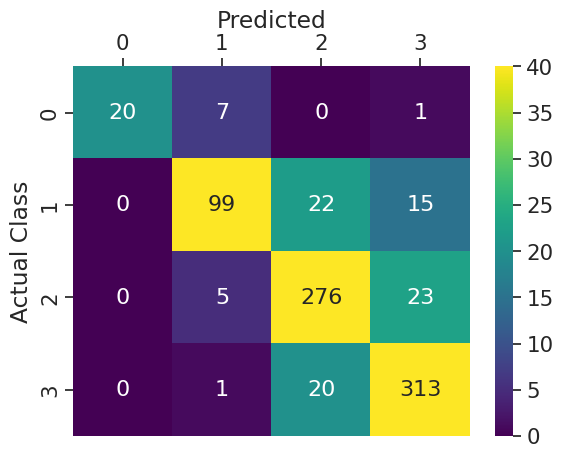

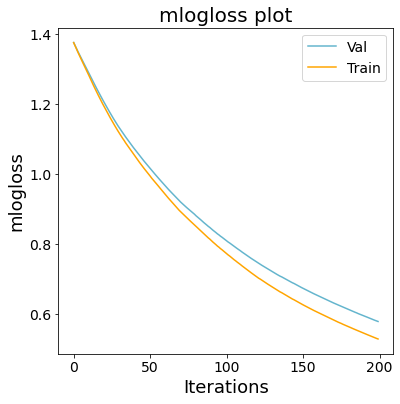

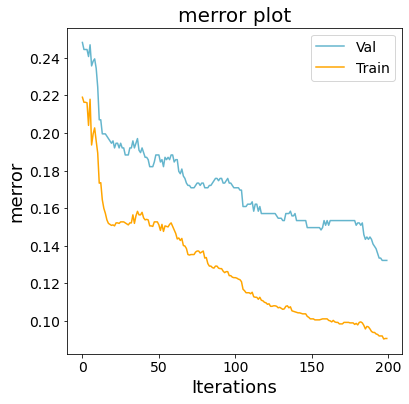

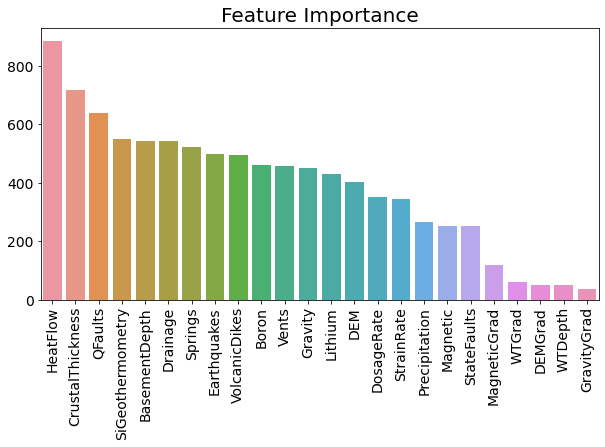

XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4,
              n_estimators=200, n_jobs=-1, objective='multi:softprob',
              reg_lambda=1.0, scale_pos_weight=1.0, seed=43, subsample=1.0)


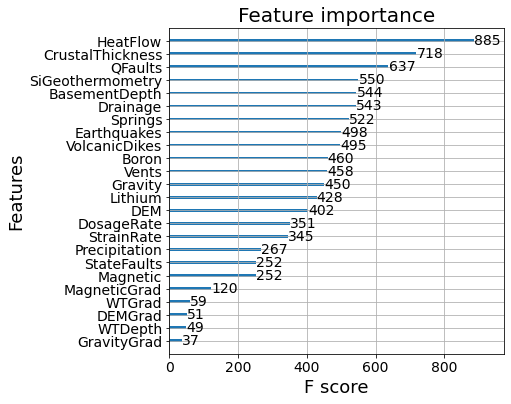

In [61]:
# Incorporate tuning results 
xgb_model2 = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1, 
                          scale_pos_weight=SPWT, 
                          seed=seed)

xgb_model2 = XGBfit(xgb_model2,
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'),  
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model2)

### Tune on min_child_weight

In [62]:
# Tuning of min_child_weight

valrng = range(1,11,1)
params_gs2 = {
  'min_child_weight':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv2 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs2, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose=10,
                       cv=cv)
gridcv2 = gridcv2.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['min_child_weight'] = gridcv2.best_params_['min_child_weight']
MINCW = best_params['min_child_weight']

getTrainScores(gridcv2)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


({0: "mean:0.9752440142727378params{'min_child_weight': 1}",
  1: "mean:0.9752547124457865params{'min_child_weight': 2}",
  2: "mean:0.9756856092276471params{'min_child_weight': 3}",
  3: "mean:0.9751537956982193params{'min_child_weight': 4}",
  4: "mean:0.975362155185849params{'min_child_weight': 5}",
  5: "mean:0.9746880981560105params{'min_child_weight': 6}",
  6: "mean:0.9738442318083018params{'min_child_weight': 7}",
  7: "mean:0.9731238935838741params{'min_child_weight': 8}",
  8: "mean:0.972325570321532params{'min_child_weight': 9}",
  9: "mean:0.9718827610994818params{'min_child_weight': 10}"},
 {'best_mean': 0.9756856092276471, 'best_param': {'min_child_weight': 3}})

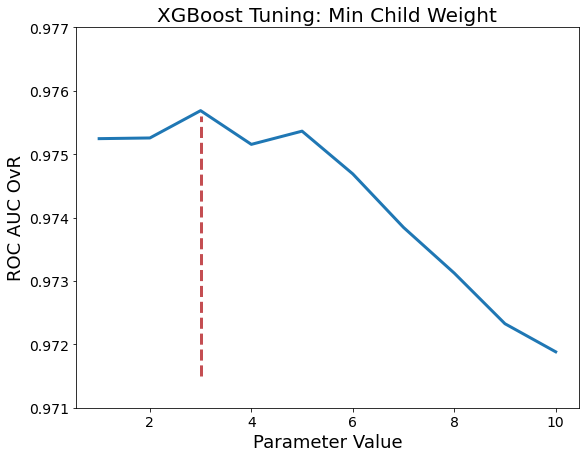

In [72]:
cv = gridcv2
with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',
           lw=3)
  plt.vlines(best_params['min_child_weight'],
             ymin=0.9715,
             ymax=0.9756,
             linestyles='dashed',
             colors='r',
             lw=3)
  plt.ylim([0.971,0.977])
  plt.title('XGBoost Tuning: Min Child Weight');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

[0]	val-mlogloss:1.37672	val-merror:0.246883	train-mlogloss:1.37615	train-merror:0.220856
[100]	val-mlogloss:0.812623	val-merror:0.159601	train-mlogloss:0.77697	train-merror:0.124064
[199]	val-mlogloss:0.58116	val-merror:0.133416	train-mlogloss:0.53331	train-merror:0.096257

XGBFit Results
Accuracy (Train) : 0.9037
Accuracy (Test)  : 0.8778
F1-weighted (Train): 0.902549
F1-weighted (Test) : 0.875263
macro AUC (Train): 0.985271
weighted AUC (Train): 0.982755
macro AUC (Test) : 0.974877
weighted AUC (Test): 0.971906
[[ 20   6   1   1]
 [  0  94  25  17]
 [  0   2 278  24]
 [  0   1  21 312]]
              precision    recall  f1-score   support

       No-GT       1.00      0.71      0.83        28
      Low-GT       0.91      0.69      0.79       136
      Med-GT       0.86      0.91      0.88       304
     High-GT       0.88      0.93      0.91       334

    accuracy                           0.88       802
   macro avg       0.91      0.81      0.85       802
weighted avg       0.88

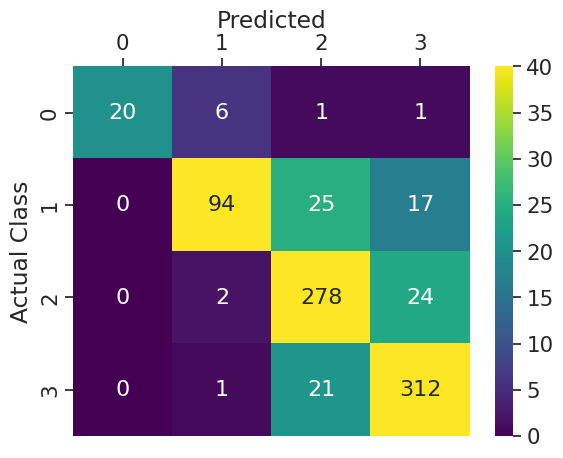

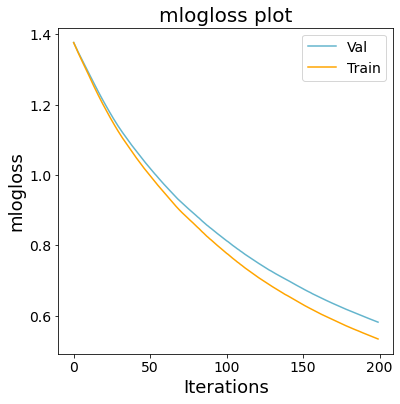

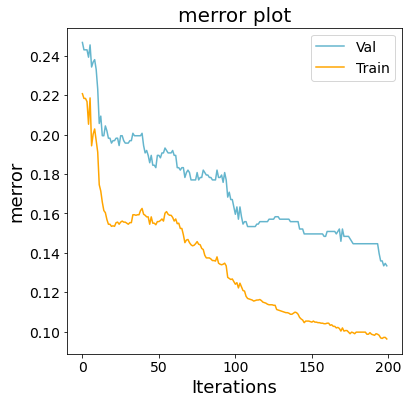

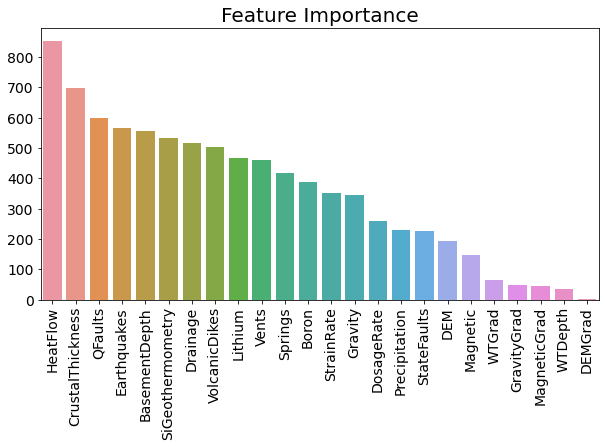

XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.0, scale_pos_weight=1.0,
              seed=43, subsample=1.0)


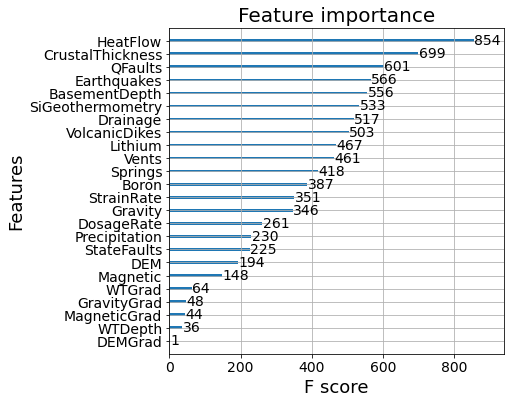

In [73]:
# Incorporate tuning results
xgb_model3 = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1, 
                          scale_pos_weight=SPWT, 
                          seed=seed)

xgb_model3 = XGBfit(xgb_model3,
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'),  
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model3)

### Tune on gamma

In [74]:
# Tuning of gamma
valrng = [i/10. for i in range(0,11)]
params_gs3 = {
 'gamma':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv3 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs3, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv3 = gridcv3.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['gamma'] = GAMMA = gridcv3.best_params_['gamma']

getTrainScores(gridcv3)

Fitting 30 folds for each of 11 candidates, totalling 330 fits


({0: "mean:0.9757313190577528params{'gamma': 0.0}",
  1: "mean:0.9756969754126302params{'gamma': 0.1}",
  2: "mean:0.9756856092276471params{'gamma': 0.2}",
  3: "mean:0.9752487879687565params{'gamma': 0.3}",
  4: "mean:0.9752318945151838params{'gamma': 0.4}",
  5: "mean:0.9752242157150787params{'gamma': 0.5}",
  6: "mean:0.9752371668839095params{'gamma': 0.6}",
  7: "mean:0.9751568577346615params{'gamma': 0.7}",
  8: "mean:0.9751768859444787params{'gamma': 0.8}",
  9: "mean:0.9751379633658043params{'gamma': 0.9}",
  10: "mean:0.9751220104406536params{'gamma': 1.0}"},
 {'best_mean': 0.9757313190577528, 'best_param': {'gamma': 0.0}})

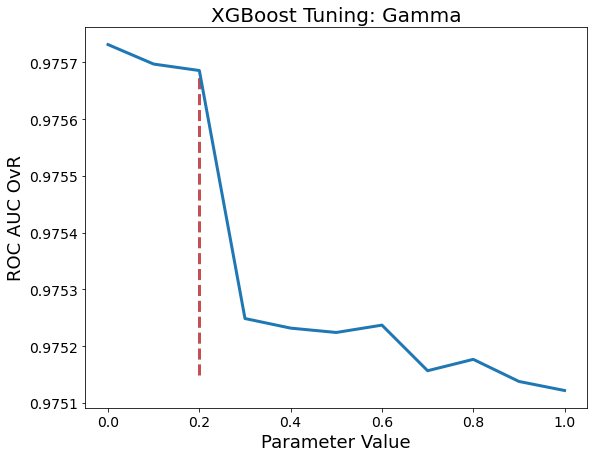

In [81]:
cv = gridcv3

best_params['gamma'] = GAMMA = .2

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['gamma'],
             ymin=0.97515,ymax=0.97568,
             linestyles='dashed',
             colors='r',lw=3)
  #plt.ylim()
  plt.title('XGBoost Tuning: Gamma');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

[0]	val-mlogloss:1.37672	val-merror:0.246883	train-mlogloss:1.37615	train-merror:0.220856
[100]	val-mlogloss:0.812623	val-merror:0.159601	train-mlogloss:0.77697	train-merror:0.124064
[199]	val-mlogloss:0.58116	val-merror:0.133416	train-mlogloss:0.53331	train-merror:0.096257

XGBFit Results
Accuracy (Train) : 0.9037
Accuracy (Test)  : 0.8778
F1-weighted (Train): 0.902549
F1-weighted (Test) : 0.875263
macro AUC (Train): 0.985271
weighted AUC (Train): 0.982755
macro AUC (Test) : 0.974877
weighted AUC (Test): 0.971906
[[ 20   6   1   1]
 [  0  94  25  17]
 [  0   2 278  24]
 [  0   1  21 312]]
              precision    recall  f1-score   support

       No-GT       1.00      0.71      0.83        28
      Low-GT       0.91      0.69      0.79       136
      Med-GT       0.86      0.91      0.88       304
     High-GT       0.88      0.93      0.91       334

    accuracy                           0.88       802
   macro avg       0.91      0.81      0.85       802
weighted avg       0.88

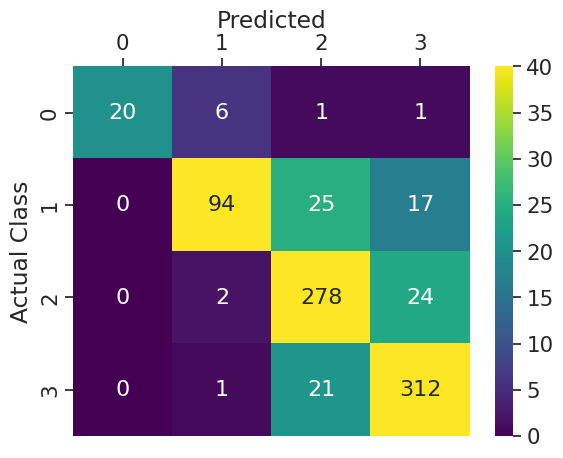

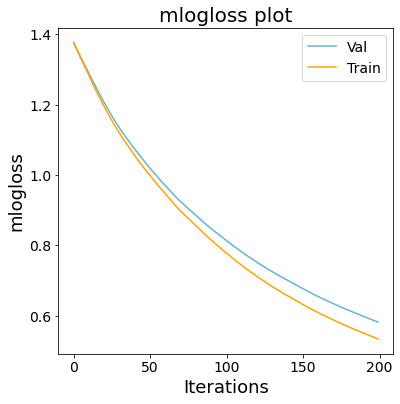

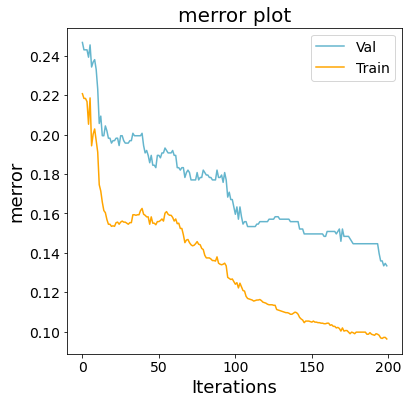

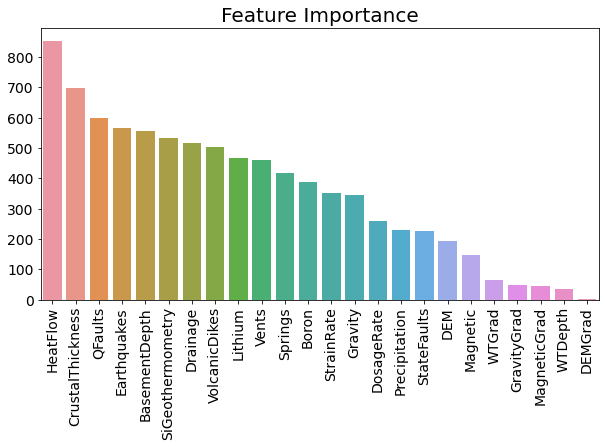

XGBClassifier(colsample_bytree=1.0, gamma=0.2, learning_rate=0.01, max_depth=4,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.0, scale_pos_weight=1.0,
              seed=43, subsample=1.0)


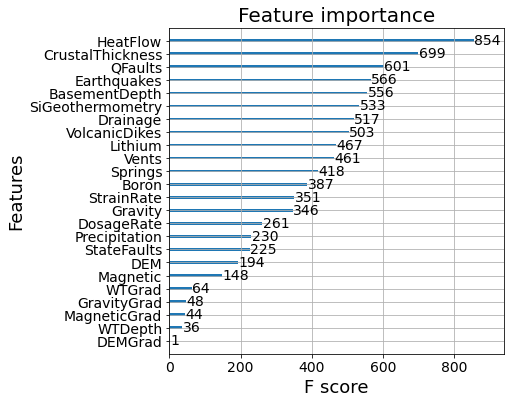

In [82]:
# Incorporate tuning results
xgb_model4 = XGBClassifier(learning_rate=LR,
                           n_estimators=NEST, 
                           max_depth=MAXD, 
                           min_child_weight=MINCW,
                           gamma=GAMMA, 
                           subsample=SSBT, 
                           colsample_bytree=CSBT,
                           reg_lambda=LAMBDA,
                           objective='multi:softprob',
                           n_jobs=-1, 
                           scale_pos_weight=SPWT, 
                           seed=seed)

xgb_model4 = XGBfit(xgb_model4, 
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'), 
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model4)

### Tune on subsample and colsample_bytree

In [84]:
# Tuning of subsample, colsample_bytree
valrng = [i/10.0 for i in range(1,11)]
params_gs4 = {
  'subsample':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv4 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs4, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv4 = gridcv4.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['subsample'] = SSBT = gridcv4.best_params_['subsample']

getTrainScores(gridcv4)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


({0: "mean:0.9704774801994378params{'subsample': 0.1}",
  1: "mean:0.9764345675019365params{'subsample': 0.2}",
  2: "mean:0.9783491511117489params{'subsample': 0.3}",
  3: "mean:0.9793935262057333params{'subsample': 0.4}",
  4: "mean:0.9795855728505912params{'subsample': 0.5}",
  5: "mean:0.9794579103532529params{'subsample': 0.6}",
  6: "mean:0.9788559333790773params{'subsample': 0.7}",
  7: "mean:0.9781941511646665params{'subsample': 0.8}",
  8: "mean:0.9772753420082195params{'subsample': 0.9}",
  9: "mean:0.9756856092276471params{'subsample': 1.0}"},
 {'best_mean': 0.9795855728505912, 'best_param': {'subsample': 0.5}})

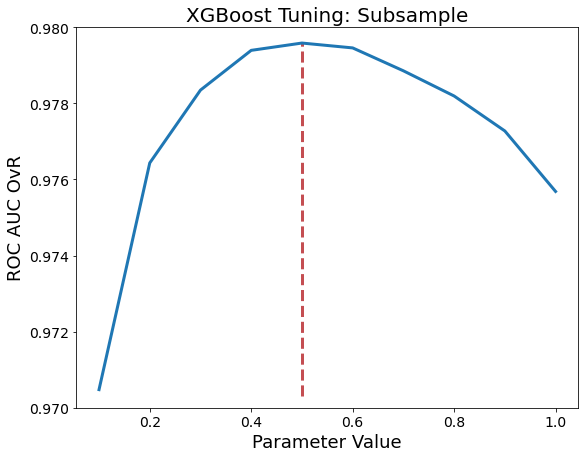

In [89]:
cv = gridcv4

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['subsample'],
             ymin=0.9703,ymax=cv.best_score_,
             linestyles='dashed',colors='r',lw=3)
  plt.ylim([0.970,0.980])
  plt.title('XGBoost Tuning: Subsample');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

In [90]:
# Tuning of subsample, colsample_bytree
valrng = [i/10.0 for i in range(1,11)]
params_gs5 = {
  'colsample_bytree':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv5 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs5, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv5 = gridcv5.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['colsample_bytree'] = CSBT = gridcv5.best_params_['colsample_bytree']

getTrainScores(gridcv5)

Fitting 30 folds for each of 10 candidates, totalling 300 fits


({0: "mean:0.967959558422795params{'colsample_bytree': 0.1}",
  1: "mean:0.9767289199834988params{'colsample_bytree': 0.2}",
  2: "mean:0.9797676242862944params{'colsample_bytree': 0.3}",
  3: "mean:0.9803802501537653params{'colsample_bytree': 0.4}",
  4: "mean:0.9807127716006699params{'colsample_bytree': 0.5}",
  5: "mean:0.9807098451116982params{'colsample_bytree': 0.6}",
  6: "mean:0.9804057969283211params{'colsample_bytree': 0.7}",
  7: "mean:0.9801593906567658params{'colsample_bytree': 0.8}",
  8: "mean:0.97986919286946params{'colsample_bytree': 0.9}",
  9: "mean:0.9795855728505912params{'colsample_bytree': 1.0}"},
 {'best_mean': 0.9807127716006699, 'best_param': {'colsample_bytree': 0.5}})

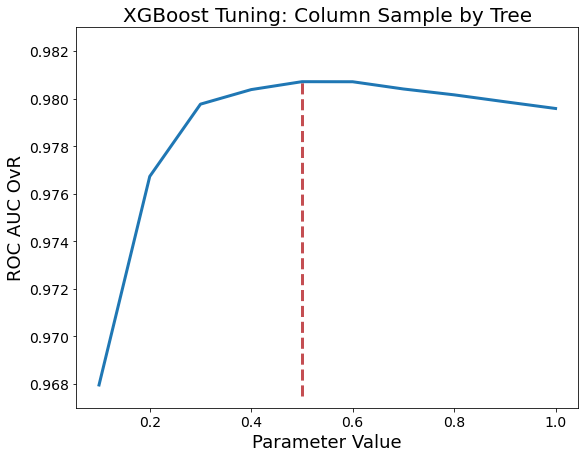

In [101]:
cv = gridcv5

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['colsample_bytree'],
             ymin=0.9675,ymax=cv.best_score_,
             linestyles='dashed',colors='r',lw=3)
  plt.ylim([0.967,0.983])
  plt.title('XGBoost Tuning: Column Sample by Tree');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

[0]	val-mlogloss:1.37632	val-merror:0.22818	train-mlogloss:1.37609	train-merror:0.222995
[100]	val-mlogloss:0.836115	val-merror:0.157107	train-mlogloss:0.806832	train-merror:0.111497
[199]	val-mlogloss:0.605979	val-merror:0.142145	train-mlogloss:0.566783	train-merror:0.097326

XGBFit Results
Accuracy (Train) : 0.9027
Accuracy (Test)  : 0.8653
F1-weighted (Train): 0.901351
F1-weighted (Test) : 0.862507
macro AUC (Train): 0.987582
weighted AUC (Train): 0.984145
macro AUC (Test) : 0.979778
weighted AUC (Test): 0.974637
[[ 18   7   2   1]
 [  0  93  18  25]
 [  0   4 276  24]
 [  0   0  27 307]]
              precision    recall  f1-score   support

       No-GT       1.00      0.64      0.78        28
      Low-GT       0.89      0.68      0.77       136
      Med-GT       0.85      0.91      0.88       304
     High-GT       0.86      0.92      0.89       334

    accuracy                           0.87       802
   macro avg       0.90      0.79      0.83       802
weighted avg       0.

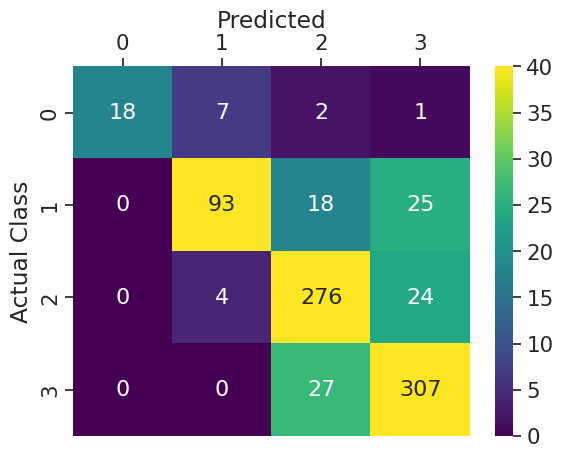

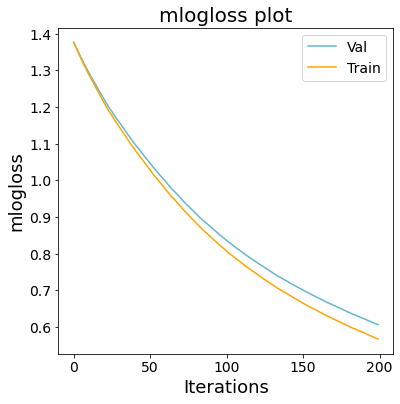

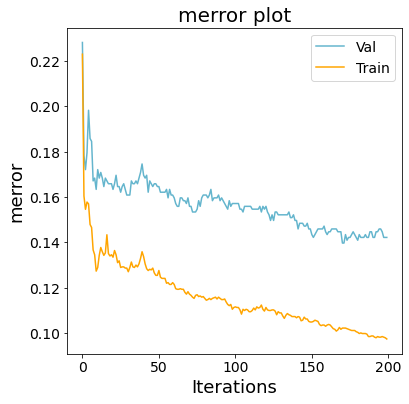

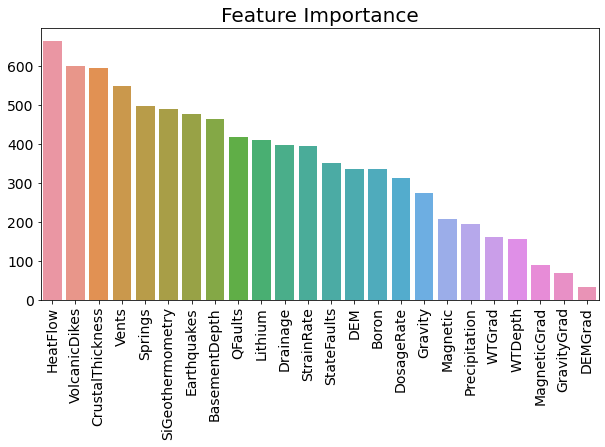

XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.01, max_depth=4,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.0, scale_pos_weight=1.0,
              seed=43, subsample=0.5)


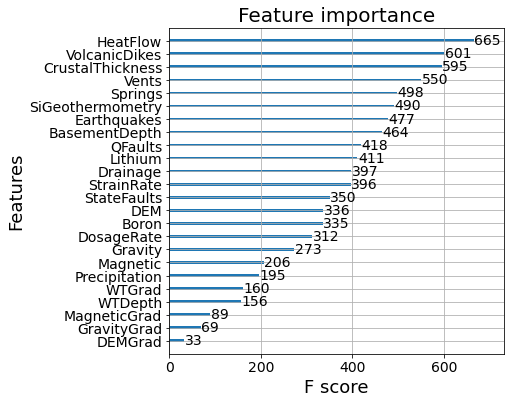

In [102]:
# Incorporate tuning results
xgb_model5 = XGBClassifier(learning_rate=LR,
                           n_estimators=NEST, 
                           max_depth=MAXD, 
                           min_child_weight=MINCW,
                           gamma=GAMMA, 
                           subsample=SSBT, 
                           colsample_bytree=CSBT,
                           reg_lambda=LAMBDA,
                           objective='multi:softprob',
                           n_jobs=-1, 
                           scale_pos_weight=SPWT, 
                           seed=seed)

xgb_model5 = XGBfit(xgb_model5, 
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'), 
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model5)

#### Test joint search = same result

In [ ]:
# Tuning of subsample, colsample_bytree
valrng = [i/10.0 for i in range(1,11)]
params_gs7 = {
  'subsample':valrng,
  'colsample_bytree':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=MAXD, 
                          min_child_weight=MINCW,
                          gamma=GAMMA, 
                          subsample=SSBT, 
                          colsample_bytree=CSBT,
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv7 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs7, 
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose=10,
                       cv=cv)

gridcv7 = gridcv7.fit(Xtrnvalsc[keepcols],yenc_trnval)

getTrainScores(gridcv7)

#### Tune on Lambda

In [103]:
# Tuning of lambda

valrng = np.logspace(-10,2,20)
params_gs8 = {
  'reg_lambda':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=best_params['max_depth'], 
                          min_child_weight=best_params['min_child_weight'],
                          gamma=best_params['gamma'], 
                          subsample=best_params['subsample'], 
                          colsample_bytree=best_params['colsample_bytree'],
                          reg_lambda=LAMBDA,
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

gridcv8 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs8,
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv8 = gridcv8.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['reg_lambda'] = LAMBDA = gridcv8.best_params_['reg_lambda']

getTrainScores(gridcv8)

Fitting 30 folds for each of 20 candidates, totalling 600 fits


({0: "mean:0.9817852686049826params{'reg_lambda': 1e-10}",
  1: "mean:0.9817852686049826params{'reg_lambda': 4.281332398719396e-10}",
  2: "mean:0.9817852686049826params{'reg_lambda': 1.8329807108324374e-09}",
  3: "mean:0.9817852686049826params{'reg_lambda': 7.847599703514623e-09}",
  4: "mean:0.9817854349887968params{'reg_lambda': 3.3598182862837814e-08}",
  5: "mean:0.9817854349887968params{'reg_lambda': 1.438449888287663e-07}",
  6: "mean:0.9817852686049826params{'reg_lambda': 6.158482110660254e-07}",
  7: "mean:0.9817852386781346params{'reg_lambda': 2.6366508987303555e-06}",
  8: "mean:0.9817852386781346params{'reg_lambda': 1.1288378916846883e-05}",
  9: "mean:0.981785067256224params{'reg_lambda': 4.8329302385717524e-05}",
  10: "mean:0.9817854934885051params{'reg_lambda': 0.00020691380811147902}",
  11: "mean:0.9817774914050209params{'reg_lambda': 0.0008858667904100814}",
  12: "mean:0.9817713490018066params{'reg_lambda': 0.003792690190732246}",
  13: "mean:0.9817634779860175para

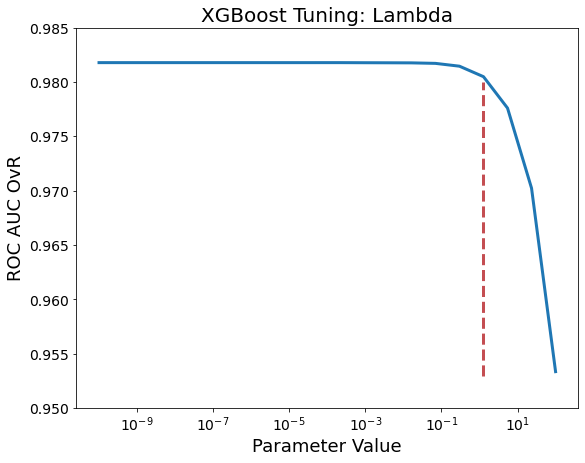

In [110]:
cv = gridcv8

best_params['reg_lambda'] = LAMBDA = 1.2742749857031321

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['reg_lambda'],
             ymin=0.953,ymax=0.980,#ymax=cv.best_score_,
             linestyles='dashed',colors='r',lw=3)
  plt.ylim([0.95,0.985])
  plt.title('XGBoost Tuning: Lambda');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');
  
  plt.gca().set_xscale('log')


[0]	val-mlogloss:1.37638	val-merror:0.226933	train-mlogloss:1.37614	train-merror:0.219786
[100]	val-mlogloss:0.83692	val-merror:0.15586	train-mlogloss:0.808341	train-merror:0.112032
[199]	val-mlogloss:0.607075	val-merror:0.140898	train-mlogloss:0.568446	train-merror:0.098663

XGBFit Results
Accuracy (Train) : 0.9013
Accuracy (Test)  : 0.8653
F1-weighted (Train): 0.899910
F1-weighted (Test) : 0.862219
macro AUC (Train): 0.987422
weighted AUC (Train): 0.983943
macro AUC (Test) : 0.979531
weighted AUC (Test): 0.974316
[[ 17   8   2   1]
 [  0  93  18  25]
 [  0   4 276  24]
 [  0   0  26 308]]
              precision    recall  f1-score   support

       No-GT       1.00      0.61      0.76        28
      Low-GT       0.89      0.68      0.77       136
      Med-GT       0.86      0.91      0.88       304
     High-GT       0.86      0.92      0.89       334

    accuracy                           0.87       802
   macro avg       0.90      0.78      0.82       802
weighted avg       0.8

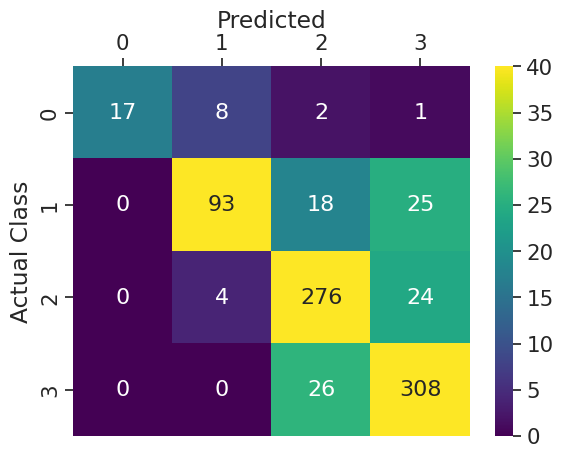

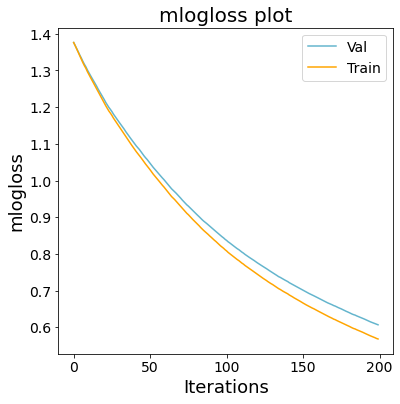

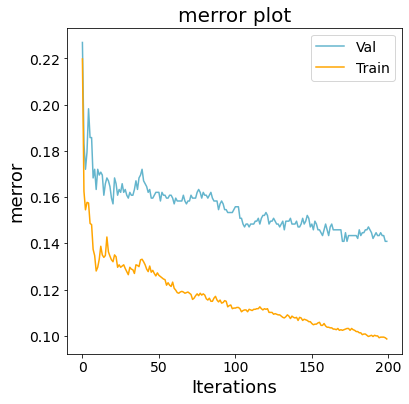

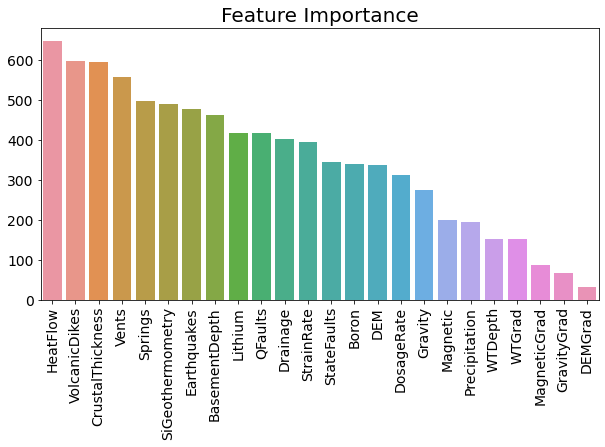

XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.01, max_depth=4,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.2742749857031321,
              scale_pos_weight=1.0, seed=43, subsample=0.5)


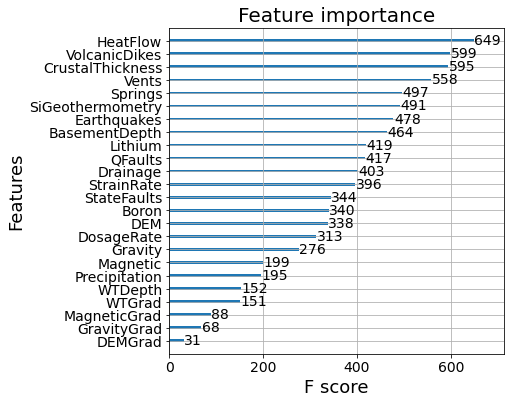

In [111]:
# Incorporate tuning results
xgb_model6 = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=best_params['max_depth'], 
                          min_child_weight=best_params['min_child_weight'],
                          gamma=best_params['gamma'], 
                          subsample=best_params['subsample'], 
                          colsample_bytree=best_params['colsample_bytree'],
                          reg_lambda=best_params['reg_lambda'],
                          objective='multi:softprob',
                          n_jobs=-1,
                          scale_pos_weight=SPWT, 
                          seed=seed)

xgb_model6 = XGBfit(xgb_model6, 
                    Xtrsc, 
                    pd.Series(yenc_trn,name='GeothermGrad'), 
                    Xvlsc, 
                    pd.Series(yenc_val,name='GeothermGrad'), 
                    Xtssc, 
                    pd.Series(yenc_tst,name='GeothermGrad'), 
                    keepcols);
print(xgb_model6)

#### Tune on Scale Positive Weight

In [112]:
# Tuning of scale_pos_weight
valrng = np.arange(0,1.1,.1)
params_gs9 = {
  'scale_pos_weight':valrng
}

# maintain stratified sampling
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=seed)

# new model for next round of grid searching
xgb_model = XGBClassifier(learning_rate=LR,
                          n_estimators=NEST, 
                          max_depth=best_params['max_depth'], 
                          min_child_weight=best_params['min_child_weight'],
                          gamma=best_params['gamma'], 
                          subsample=best_params['subsample'], 
                          colsample_bytree=best_params['colsample_bytree'],
                          reg_lambda=best_params['reg_lambda'],
                          scale_pos_weight=SPWT, 
                          objective='multi:softprob',
                          n_jobs=-1,
                          seed=seed)

gridcv9 = GridSearchCV(estimator=xgb_model,
                       param_grid=params_gs9,
                       scoring='roc_auc_ovr',
                       n_jobs=-1,
                       verbose = 10,
                       cv=cv)

gridcv9 = gridcv9.fit(Xtrnvalsc[keepcols],yenc_trnval)

# record best results
best_params['scale_pos_weight'] = SPWT = gridcv9.best_params_['scale_pos_weight']

getTrainScores(gridcv9)

Fitting 30 folds for each of 11 candidates, totalling 330 fits


({0: "mean:0.9804923673060041params{'scale_pos_weight': 0.0}",
  1: "mean:0.9804923673060041params{'scale_pos_weight': 0.1}",
  2: "mean:0.9804923673060041params{'scale_pos_weight': 0.2}",
  3: "mean:0.9804923673060041params{'scale_pos_weight': 0.30000000000000004}",
  4: "mean:0.9804923673060041params{'scale_pos_weight': 0.4}",
  5: "mean:0.9804923673060041params{'scale_pos_weight': 0.5}",
  6: "mean:0.9804923673060041params{'scale_pos_weight': 0.6000000000000001}",
  7: "mean:0.9804923673060041params{'scale_pos_weight': 0.7000000000000001}",
  8: "mean:0.9804923673060041params{'scale_pos_weight': 0.8}",
  9: "mean:0.9804923673060041params{'scale_pos_weight': 0.9}",
  10: "mean:0.9804923673060041params{'scale_pos_weight': 1.0}"},
 {'best_mean': 0.9804923673060041, 'best_param': {'scale_pos_weight': 0.0}})

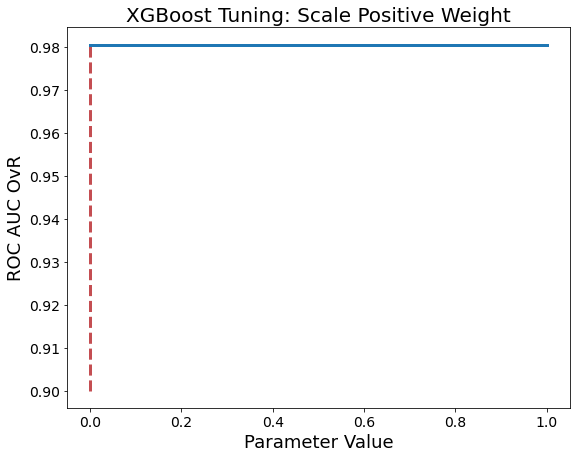

In [113]:
cv = gridcv9

with mpl.style.context('seaborn-muted'):
  plt.figure(figsize=(9,7))
  plt.plot(valrng,
           cv.cv_results_['mean_test_score'],
           c='#1F77B4',lw=3)
  plt.vlines(best_params['scale_pos_weight'],
             ymin=0.9,ymax=cv.best_score_,
             linestyles='dashed',colors='r',lw=3)
  plt.title('XGBoost Tuning: Scale Positive Weight');
  plt.ylabel('ROC AUC OvR');
  plt.xlabel('Parameter Value');

[0]	val-mlogloss:1.37638	val-merror:0.226933	train-mlogloss:1.37614	train-merror:0.219786
[100]	val-mlogloss:0.83692	val-merror:0.15586	train-mlogloss:0.808341	train-merror:0.112032
[199]	val-mlogloss:0.607075	val-merror:0.140898	train-mlogloss:0.568446	train-merror:0.098663

XGBFit Results
Accuracy (Train) : 0.9013
Accuracy (Test)  : 0.8653
F1-weighted (Train): 0.899910
F1-weighted (Test) : 0.862219
macro AUC (Train): 0.987422
weighted AUC (Train): 0.983943
macro AUC (Test) : 0.979531
weighted AUC (Test): 0.974316
[[ 17   8   2   1]
 [  0  93  18  25]
 [  0   4 276  24]
 [  0   0  26 308]]
              precision    recall  f1-score   support

       No-GT       1.00      0.61      0.76        28
      Low-GT       0.89      0.68      0.77       136
      Med-GT       0.86      0.91      0.88       304
     High-GT       0.86      0.92      0.89       334

    accuracy                           0.87       802
   macro avg       0.90      0.78      0.82       802
weighted avg       0.8

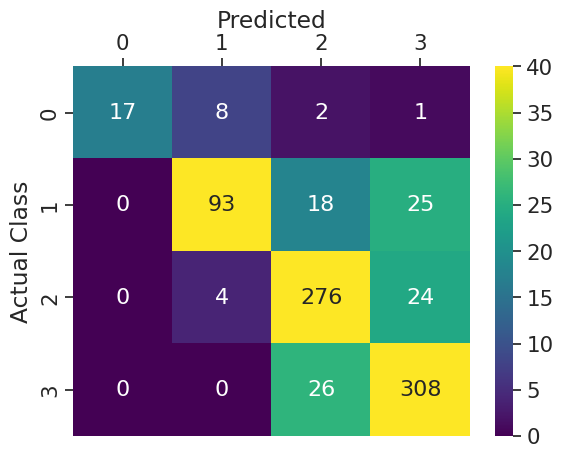

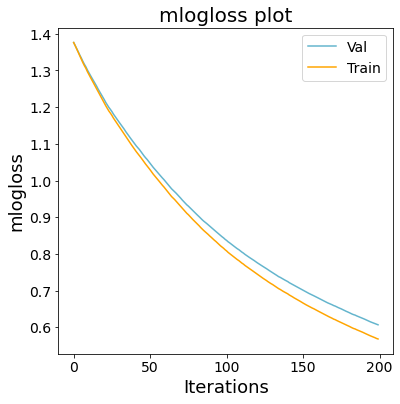

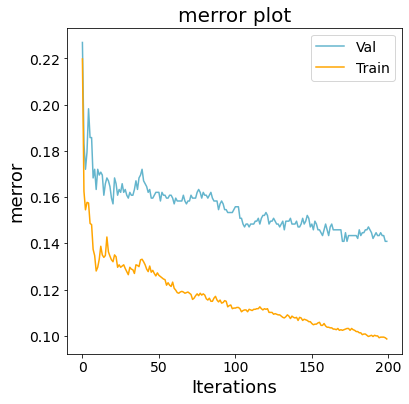

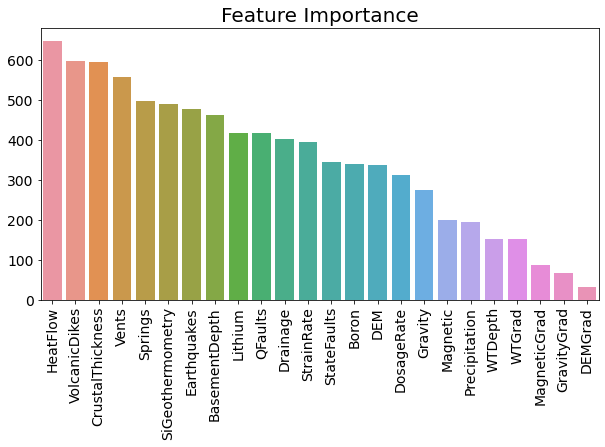

XGBClassifier(colsample_bytree=0.5, gamma=0.2, learning_rate=0.01, max_depth=4,
              min_child_weight=3, n_estimators=200, n_jobs=-1,
              objective='multi:softprob', reg_lambda=1.2742749857031321,
              scale_pos_weight=0.0, seed=43, subsample=0.5)


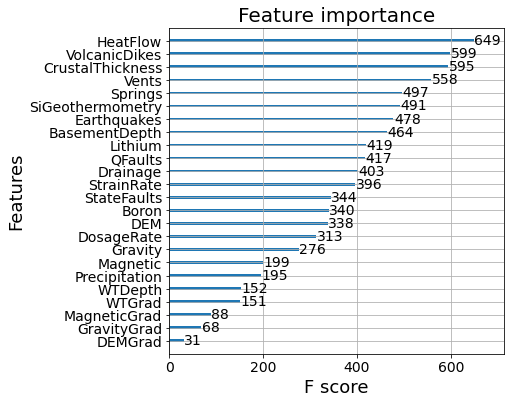

In [114]:
# Incorporate tuning results
xgb_model7 = XGBClassifier(learning_rate=LR,
                            n_estimators=NEST,
                            max_depth=best_params['max_depth'], 
                            min_child_weight=best_params['min_child_weight'],
                            gamma=best_params['gamma'], 
                            subsample=best_params['subsample'], 
                            colsample_bytree=best_params['colsample_bytree'],
                            reg_lambda=best_params['reg_lambda'],
                            scale_pos_weight=best_params['scale_pos_weight'],
                            objective='multi:softprob',
                            n_jobs=-1,
                            seed=seed)
                          
xgb_model7 = XGBfit(xgb_model7,
                    Xtrsc,
                    pd.Series(yenc_trn,name='GeothermGrad'),
                    Xvlsc,
                    pd.Series(yenc_val,name='GeothermGrad'),
                    Xtssc,
                    pd.Series(yenc_tst,name='GeothermGrad'),
                    keepcols);
print(xgb_model7)

### NOTE: no difference with changing scale_pos_weight!

### Create final model and plot ROC curves

In [123]:
RESET_BEST_PARAMS = True
VERSION = 8

if RESET_BEST_PARAMS:
  if VERSION == 4:
    best_params = {'max_depth': 5,
                  'min_child_weight': 3,
                  'gamma': 0.1,
                  'subsample': 0.6,
                  'colsample_bytree': 0.5,
                  'reg_lambda': 1.2742749857031321,
                  'scale_pos_weight': 0.0,
                  'learning_rate':0.005,
                  'n_estimators':1000}
  elif VERSION == 8:
    best_params = {'max_depth': 4,
                  'min_child_weight': 3,
                  'gamma': 0.2,
                  'subsample': 0.5,
                  'colsample_bytree': 0.5,
                  'reg_lambda': 1.2742749857031321,
                  'scale_pos_weight': 0.0,
                  'learning_rate':0.005,
                  'n_estimators':1750}
  else:
    best_params = {'max_depth': 5,
                  'min_child_weight': 7,
                  'gamma': 0.1,
                  'subsample': 0.5,
                  'colsample_bytree': 0.6,
                  'reg_lambda': 1.2742749857031321,
                  'scale_pos_weight': 0.0,
                  'learning_rate':0.005,
                  'n_estimators':1000}    
else:
  best_params['n_estimators'] = NEST = 1000
  best_params['learning_rate'] = LR = 0.005

best_params

{'colsample_bytree': 0.5,
 'gamma': 0.2,
 'learning_rate': 0.005,
 'max_depth': 4,
 'min_child_weight': 3,
 'n_estimators': 1750,
 'reg_lambda': 1.2742749857031321,
 'scale_pos_weight': 0.0,
 'subsample': 0.5}

[0]	val-mlogloss:1.38133	val-merror:0.226933	train-mlogloss:1.38121	train-merror:0.219786
[100]	val-mlogloss:1.04523	val-merror:0.17207	train-mlogloss:1.02629	train-merror:0.126203
[200]	val-mlogloss:0.839699	val-merror:0.164589	train-mlogloss:0.810214	train-merror:0.116578
[300]	val-mlogloss:0.703156	val-merror:0.154613	train-mlogloss:0.666933	train-merror:0.108021
[400]	val-mlogloss:0.604275	val-merror:0.142145	train-mlogloss:0.563991	train-merror:0.09893
[500]	val-mlogloss:0.533682	val-merror:0.13591	train-mlogloss:0.491262	train-merror:0.094118
[600]	val-mlogloss:0.478222	val-merror:0.127182	train-mlogloss:0.433874	train-merror:0.087166
[700]	val-mlogloss:0.433648	val-merror:0.118454	train-mlogloss:0.388035	train-merror:0.080481
[800]	val-mlogloss:0.396601	val-merror:0.114713	train-mlogloss:0.350294	train-merror:0.073529
[900]	val-mlogloss:0.367176	val-merror:0.100998	train-mlogloss:0.319642	train-merror:0.064438
[1000]	val-mlogloss:0.342318	val-merror:0.088529	train-mlogloss:0.293

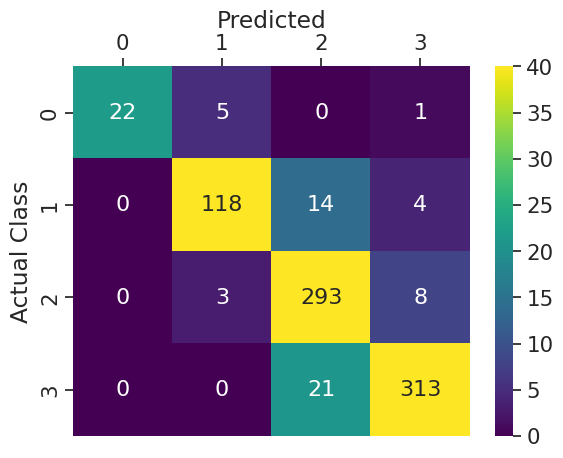

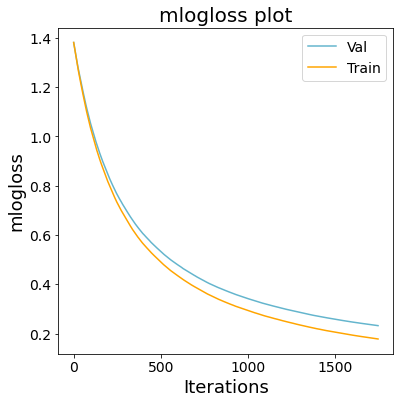

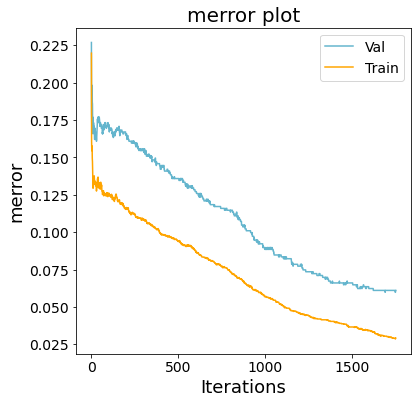

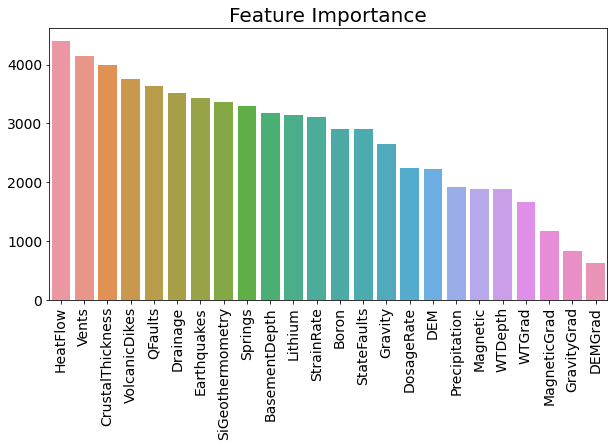

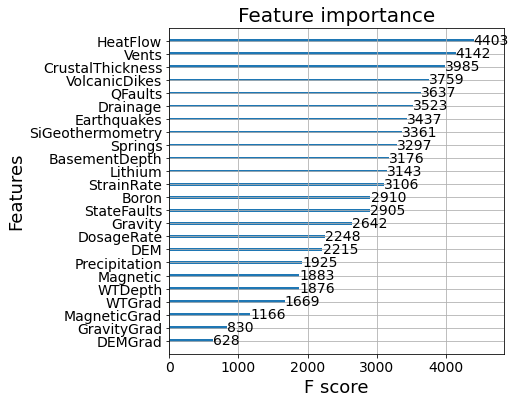

In [124]:
xgb_model_fin = XGBClassifier(learning_rate=best_params['learning_rate'],
                              n_estimators=best_params['n_estimators'],
                              max_depth=best_params['max_depth'], 
                              min_child_weight=best_params['min_child_weight'],
                              gamma=best_params['gamma'], 
                              subsample=best_params['subsample'], 
                              colsample_bytree=best_params['colsample_bytree'],
                              reg_lambda=best_params['reg_lambda'],
                              scale_pos_weight=best_params['scale_pos_weight'],
                              objective='multi:softprob',
                              n_jobs=-1,
                              seed=seed)

xgb_model_fin = XGBfit(xgb_model_fin,
                       Xtrsc,
                       pd.Series(yenc_trn,name='GeothermGrad'),
                       Xvlsc,
                       pd.Series(yenc_val,name='GeothermGrad'),
                       Xtssc,
                       pd.Series(yenc_tst,name='GeothermGrad'),
                       colnames, 
                       savefig=True);

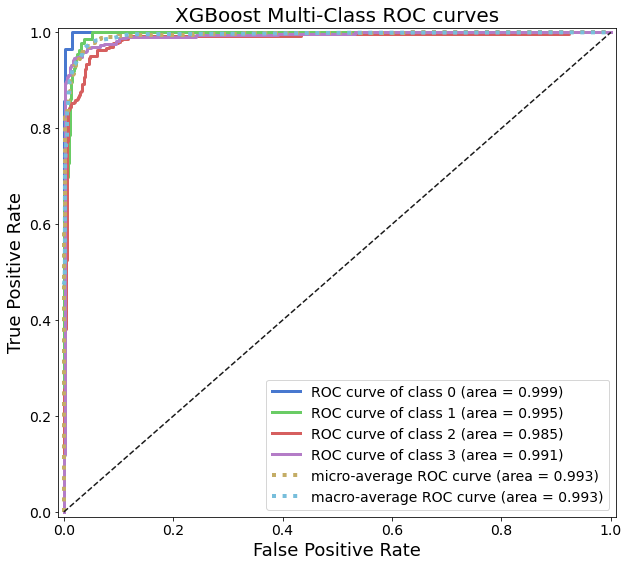

In [125]:
## from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import matplotlib as mpl

predprobs_test = xgb_model_fin.predict_proba(Xtssc[colnames])
preds_test     = np.argmax(predprobs_test, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes=[0,1,2,3]
n_classes = len(classes)
yt_bin = label_binarize(yenc_tst, classes=classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt_bin[:,i], predprobs_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yt_bin.ravel(), predprobs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(yt_bin.ravel(), predprobs_test.ravel())
#roc_auc['micro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='micro',multi_class='ovr')
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='macro',multi_class='ovr')
#roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 3
with mpl.style.context("seaborn-muted"):
  plt.figure(figsize=(10,9))

  colors = cycle(['#4A67BF','#8C8C8C','#73A96C','#AD5153'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], lw=lw,   #color=color,lw=lw,alpha=.5,
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))

  plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.3f})'
                  ''.format(roc_auc["micro"]),
            linestyle=':', lw=(lw+1))  #color='#C98AC1',alpha=.5

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
           linestyle=':', lw=(lw+1))  #color='#82B3CC', lw=lw,alpha=.5
           
  plt.plot([0, 1], [0, 1], 'k--') #, lw=lw, alpha=0.5
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('XGBoost Multi-Class ROC curves')
  plt.legend(loc="lower right")
  plt.savefig(datafolder / 'XGBoost_WDS8_ROCplot.png', bbox_inches='tight')
  plt.show()

#### Grab some stats

In [126]:
from sklearn.metrics import accuracy_score, roc_auc_score

xgb_model_fin.fit(Xtrsc,yenc_trn)

print('Training accuracy: {}'.format(accuracy_score(yenc_trn,xgb_model_fin.predict(Xtrsc))))
print('Testing accuracy: {}'.format(accuracy_score(yenc_tst,xgb_model_fin.predict(Xtssc))))

roctrn = roc_auc_score(yenc_trn, xgb_model_fin.predict_proba(Xtrsc), multi_class='ovr')
print('AUC train: {}'.format(roctrn))
  
roctest = roc_auc_score(yenc_tst, xgb_model_fin.predict_proba(Xtssc), multi_class='ovr')
print('AUC test: {}'.format(roctest))
print(best_params)

Training accuracy: 0.970855614973262
Testing accuracy: 0.9301745635910225
AUC train: 0.9982950456690589
AUC test: 0.9927361252179807
{'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.2, 'subsample': 0.5, 'colsample_bytree': 0.5, 'reg_lambda': 1.2742749857031321, 'scale_pos_weight': 0.0, 'learning_rate': 0.005, 'n_estimators': 1750}


## Load full dataset and predict

In [127]:
# load full map dataset
with open(datafolder/ "full_shared.pkl","rb") as handle: 
    datadict = pkl.load(handle)
    
# unpack
FULLdf     = datadict['data']
FULLcoords = datadict['coords']

pfa_result = FULLdf['GeothermGrad_4class']
FULLdf = FULLdf[colnames]
FULLdfsc = pd.DataFrame(pl.transform(FULLdf), columns=colnames)

# use all data
Xallsc = pd.concat([Xtrsc[colnames],Xvlsc[colnames],Xtssc[colnames]])
yenc_all=np.append(np.append(yenc_trn,yenc_val),yenc_tst)

#### train on all data for final predictive model

In [128]:
xgb_model_fin = XGBClassifier(learning_rate=best_params['learning_rate'],
                              n_estimators=best_params['n_estimators'],
                              max_depth=best_params['max_depth'], 
                              min_child_weight=best_params['min_child_weight'],
                              gamma=best_params['gamma'], 
                              subsample=best_params['subsample'], 
                              colsample_bytree=best_params['colsample_bytree'],
                              reg_lambda=best_params['reg_lambda'],
                              scale_pos_weight=best_params['scale_pos_weight'],
                              objective='multi:softprob',
                              n_jobs=-1,
                              seed=seed)
xgb_model_fin = xgb_model_fin.fit(Xallsc, yenc_all)

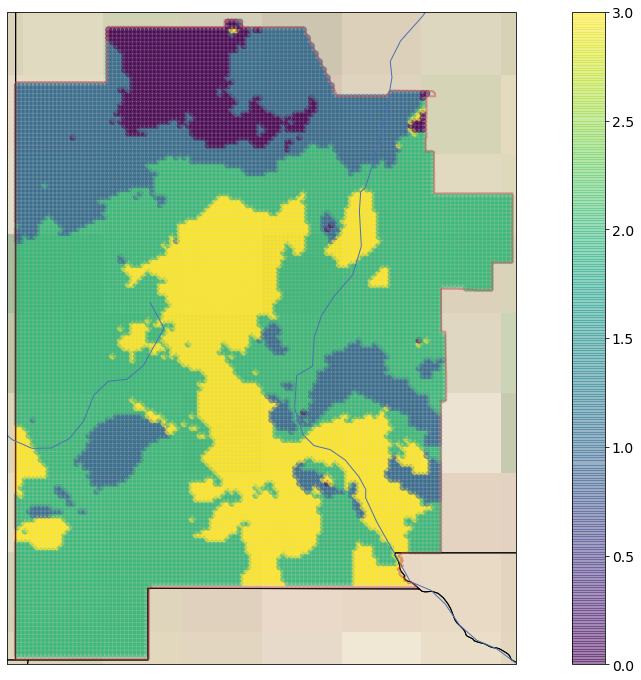

In [129]:
# predict result
FULL_ypred = xgb_model_fin.predict(FULLdfsc)
FULL_ypred_proba = xgb_model_fin.predict_proba(FULLdfsc)

# plot result
ax = createBasemap();
gdf = gpd.GeoDataFrame(FULLcoords, 
                       geometry=gpd.points_from_xy(FULLcoords.Longitude, FULLcoords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(FULLcoords.Longitude,
                FULLcoords.Latitude,
                cmap='viridis',
                c=FULL_ypred,
                alpha=0.5,
                transform=myprojection);
plt.colorbar(pc);
#plt.savefig(datafolder / 'xgboost_model_prediction_map.png')
#plt.savefig(datafolder / 'xgboost_model_prediction_map.pdf')

### Save model and results for ALL features

In [130]:
outname = datafolder / 'xgb_model_fin_allfeat.json'
#xgb_model_fin.save_model(str(outname))

# save out for use in other scripts
shared = {
          "coords":FULLcoords,
          "model":xgb_model_fin,
          "full_dataset":FULLdf,
          "selected_columns":colnames,
          "test_yc_pred":preds_test,
          "test_yc_pred_proba":predprobs_test,
          "full_yc_pred":FULL_ypred,
          "full_yc_pred_proba":FULL_ypred_proba
         }
#with open(datafolder / "gradient_class_prediction_xgb.pkl","wb") as handle:
#    pkl.dump(shared, handle, protocol=pkl.HIGHEST_PROTOCOL)


## Shapley results
####https://www.analyticsvidhya.com/blog/2019/11/shapley-value-machine-learning-interpretability-game-theory/
####https://medium.com/dataman-in-ai/the-shap-with-more-elegant-charts-bc3e73fa1c0c

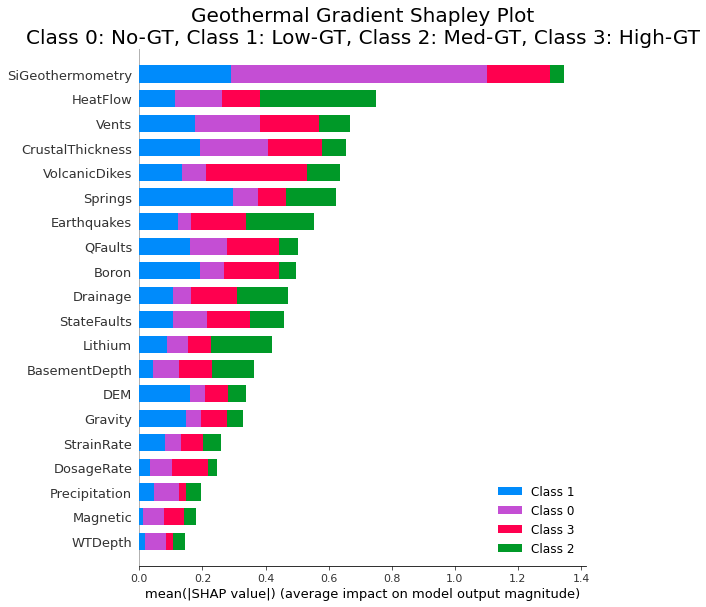

In [131]:
explainer = shap.TreeExplainer(xgb_model_fin)#, features=keepcols)oxima
shap_values = explainer.shap_values(Xtssc ,check_additivity=True)
plt.title('Geothermal Gradient Shapley Plot'+'\n'+'Class 0: No-GT, Class 1: Low-GT, Class 2: Med-GT, Class 3: High-GT')
f = shap.summary_plot(shap_values, Xtssc, plot_type="bar",show=False)
#plt.savefig(datafolder / 'xgb_shapley.png')
plt.show()

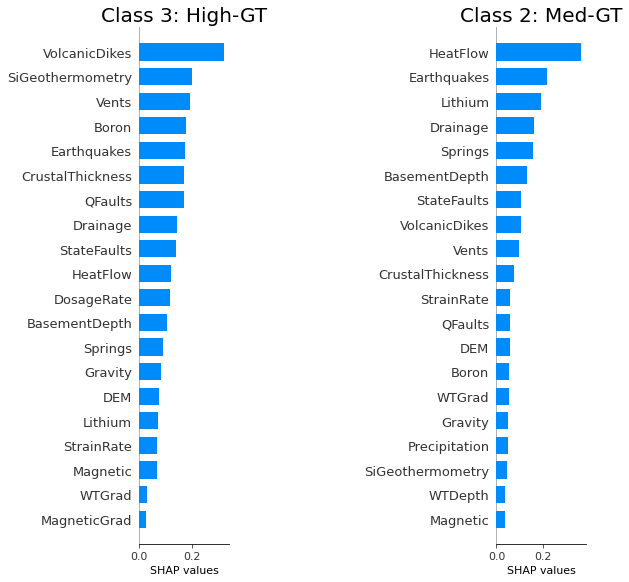

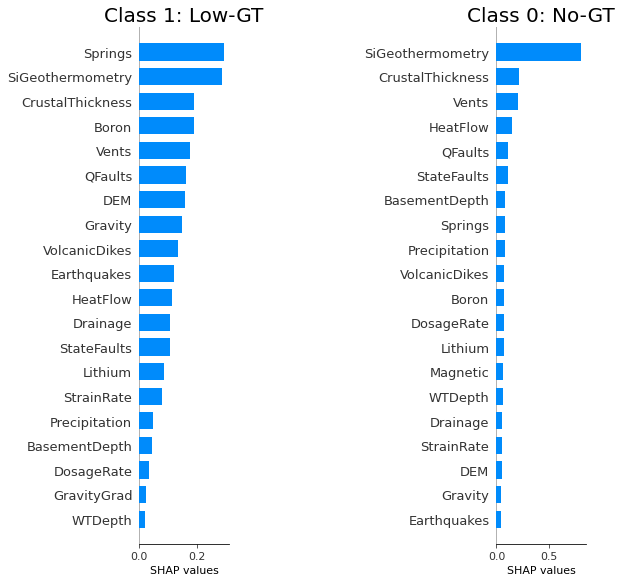

In [132]:
fig = plt.figure(figsize=(30,10))

ax0 = fig.add_subplot(121)
ax0.title.set_text('Class 3: High-GT')
shap.summary_plot(shap_values[3], Xtssc[colnames], plot_type="bar", show=False)
ax0.set_xlabel(r'SHAP values', fontsize=11)
plt.subplots_adjust(wspace = 3)

ax1 = fig.add_subplot(122)
ax1.title.set_text('Class 2: Med-GT')
shap.summary_plot(shap_values[2], Xtssc[colnames], plot_type="bar", show=False)
ax1.set_xlabel(r'SHAP values', fontsize=11)
#plt.savefig(datafolder / 'xgb_shapley_classplots1.png')

fig = plt.figure(figsize=(30,10))

ax2 = fig.add_subplot(121)
ax2.title.set_text('Class 1: Low-GT')
shap.summary_plot(shap_values[1], Xtssc[colnames], plot_type="bar", show=False)
ax2.set_xlabel(r'SHAP values', fontsize=11)
plt.subplots_adjust(wspace = 3)

ax3 = fig.add_subplot(122)
ax3.title.set_text('Class 0: No-GT')
shap.summary_plot(shap_values[0], Xtssc[colnames], plot_type="bar", show=False)
ax3.set_xlabel(r'SHAP values', fontsize=11)

#plt.savefig(datafolder / 'xgb_shapley_classplots2.png')
plt.show()

## Drop Low-Importance Features

In [133]:
# use same dropcols as WDS4 model
shap_dropcols = ['DosageRate','Precipitation','Magnetic','WTGrad','WTDepth', 'DEMGrad','GravityGrad','MagneticGrad']
fs_keepcols = [f for f in Xtrsc.columns if f not in shap_dropcols]
fs_keepcols

['DEM',
 'Gravity',
 'BasementDepth',
 'CrustalThickness',
 'StrainRate',
 'QFaults',
 'StateFaults',
 'Drainage',
 'VolcanicDikes',
 'SiGeothermometry',
 'Lithium',
 'Boron',
 'HeatFlow',
 'Earthquakes',
 'Vents',
 'Springs']

[0]	val-mlogloss:1.38198	val-merror:0.256858	train-mlogloss:1.38172	train-merror:0.229412
[100]	val-mlogloss:1.04281	val-merror:0.178304	train-mlogloss:1.02467	train-merror:0.138503
[200]	val-mlogloss:0.836791	val-merror:0.165835	train-mlogloss:0.808744	train-merror:0.124064
[300]	val-mlogloss:0.701912	val-merror:0.153367	train-mlogloss:0.667705	train-merror:0.110428
[400]	val-mlogloss:0.604255	val-merror:0.144638	train-mlogloss:0.566235	train-merror:0.102674
[500]	val-mlogloss:0.533653	val-merror:0.13591	train-mlogloss:0.492751	train-merror:0.097326
[600]	val-mlogloss:0.479487	val-merror:0.129676	train-mlogloss:0.436513	train-merror:0.091444
[700]	val-mlogloss:0.43719	val-merror:0.122195	train-mlogloss:0.392654	train-merror:0.087433
[800]	val-mlogloss:0.402086	val-merror:0.112219	train-mlogloss:0.356005	train-merror:0.079144
[900]	val-mlogloss:0.372379	val-merror:0.103491	train-mlogloss:0.325324	train-merror:0.06738
[1000]	val-mlogloss:0.347291	val-merror:0.091022	train-mlogloss:0.299

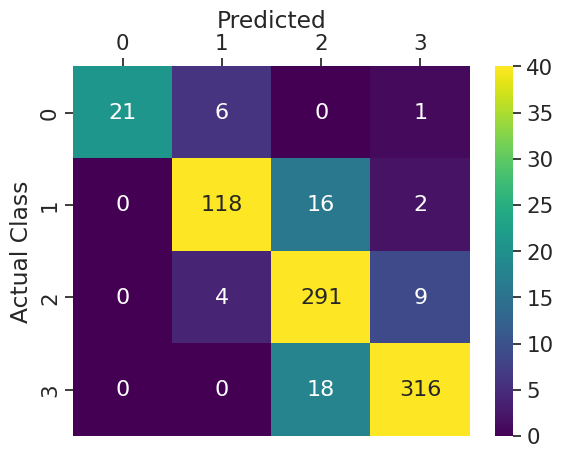

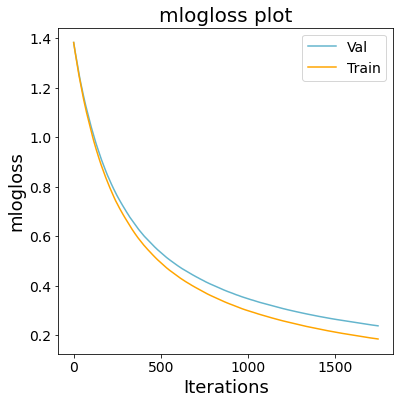

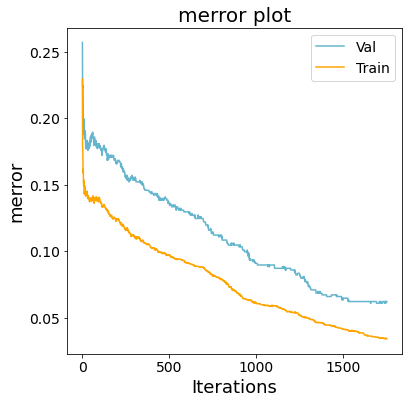

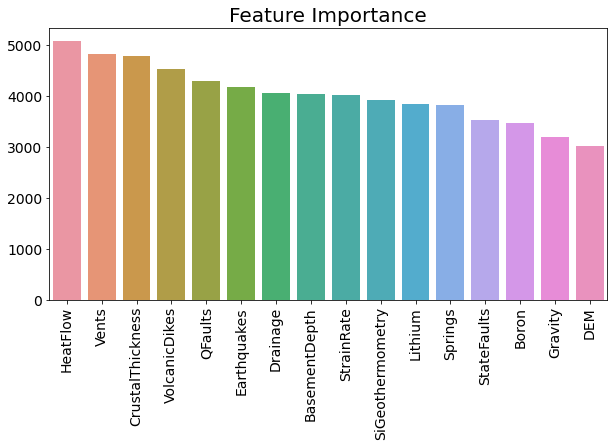

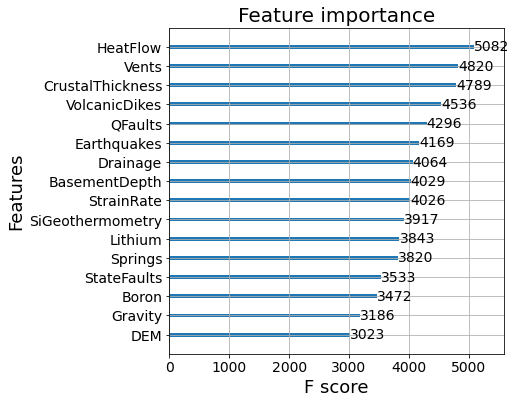

In [134]:
xgb_model_fin16 = XGBClassifier(learning_rate=best_params['learning_rate'],
                                n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'], 
                                min_child_weight=best_params['min_child_weight'],
                                gamma=best_params['gamma'], 
                                subsample=best_params['subsample'], 
                                colsample_bytree=best_params['colsample_bytree'],
                                reg_lambda=best_params['reg_lambda'],
                                scale_pos_weight=best_params['scale_pos_weight'],
                                objective='multi:softprob',
                                n_jobs=-1,
                                seed=seed)

xgb_model_fin16 = XGBfit(xgb_model_fin16,
                          Xtrsc[fs_keepcols],
                          pd.Series(yenc_trn,name='GeothermGrad'),
                          Xvlsc[fs_keepcols],
                          pd.Series(yenc_val,name='GeothermGrad'),
                          Xtssc[fs_keepcols],
                          pd.Series(yenc_tst,name='GeothermGrad'),
                          fs_keepcols);

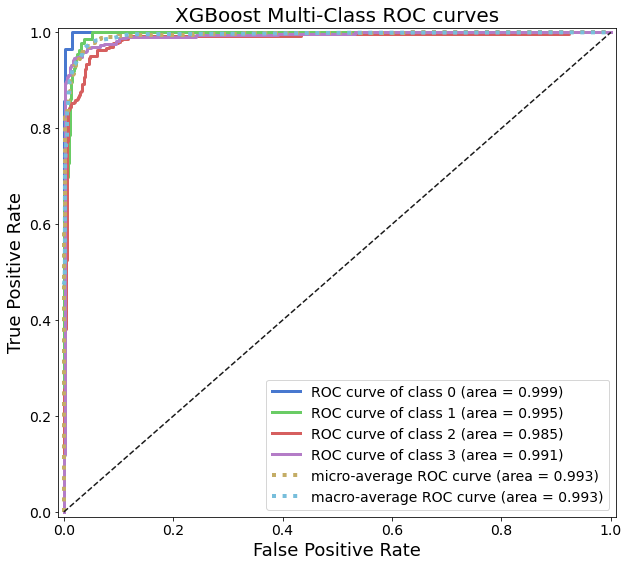

In [135]:
## from https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html#area-under-roc-for-the-multiclass-problem
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc, roc_auc_score
from itertools import cycle
import matplotlib as mpl

predprobs_test16 = xgb_model_fin16.predict_proba(Xtssc[fs_keepcols])
preds_test16     = np.argmax(predprobs_test, axis=1)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()

classes=[0,1,2,3]
n_classes = len(classes)
yt_bin = label_binarize(yenc_tst, classes=classes)
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(yt_bin[:,i], predprobs_test[:,i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(yt_bin.ravel(), predprobs_test.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

# Compute micro-average ROC curve and ROC area
fpr['micro'], tpr['micro'], _ = roc_curve(yt_bin.ravel(), predprobs_test.ravel())
#roc_auc['micro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='micro',multi_class='ovr')
roc_auc['micro'] = auc(fpr['micro'], tpr['micro'])

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr['macro'] = all_fpr
tpr['macro'] = mean_tpr
roc_auc['macro'] = metrics.roc_auc_score(yenc_tst, predprobs_test, average='macro',multi_class='ovr')
#roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
lw = 3
with mpl.style.context("seaborn-muted"):
  plt.figure(figsize=(10,9))

  colors = cycle(['#4A67BF','#8C8C8C','#73A96C','#AD5153'])
  for i, color in zip(range(n_classes), colors):
      plt.plot(fpr[i], tpr[i], lw=lw,   #color=color,lw=lw,alpha=.5,
              label='ROC curve of class {0} (area = {1:0.3f})'
              ''.format(i, roc_auc[i]))

  plt.plot(fpr["micro"], tpr["micro"],
            label='micro-average ROC curve (area = {0:0.3f})'
                  ''.format(roc_auc["micro"]),
            linestyle=':', lw=(lw+1))  #color='#C98AC1',alpha=.5

  plt.plot(fpr["macro"], tpr["macro"],
          label='macro-average ROC curve (area = {0:0.3f})'
                ''.format(roc_auc["macro"]),
           linestyle=':', lw=(lw+1))  #color='#82B3CC', lw=lw,alpha=.5
           
  plt.plot([0, 1], [0, 1], 'k--') #, lw=lw, alpha=0.5
  plt.xlim([-0.01, 1.01])
  plt.ylim([-0.01, 1.01])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('XGBoost Multi-Class ROC curves')
  plt.legend(loc="lower right")
  #plt.savefig(datafolder / 'XGBoost16_WDS_ROCplot.png')
  plt.show()

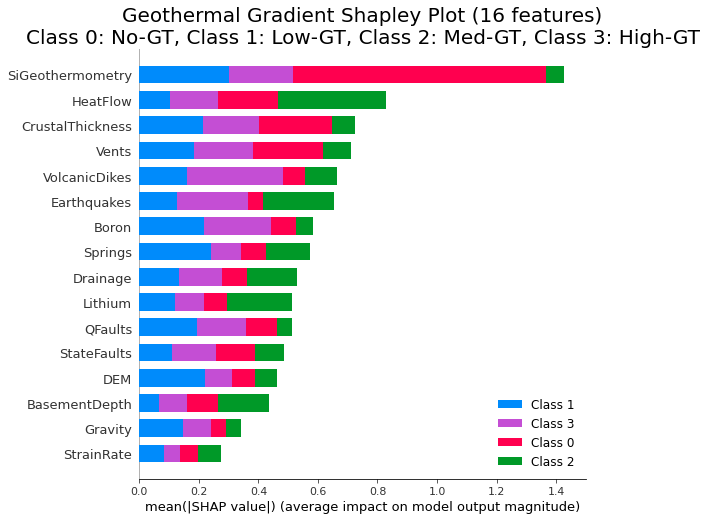

In [136]:
explainer = shap.TreeExplainer(xgb_model_fin16)
shap_values = explainer.shap_values(Xtssc[fs_keepcols],check_additivity=True)
plt.title('Geothermal Gradient Shapley Plot (16 features)'+'\n'+'Class 0: No-GT, Class 1: Low-GT, Class 2: Med-GT, Class 3: High-GT')
f = shap.summary_plot(shap_values, Xtssc[fs_keepcols], plot_type="bar",show=False)
#plt.savefig(datafolder / 'xgb16_shapley.png')
plt.show()

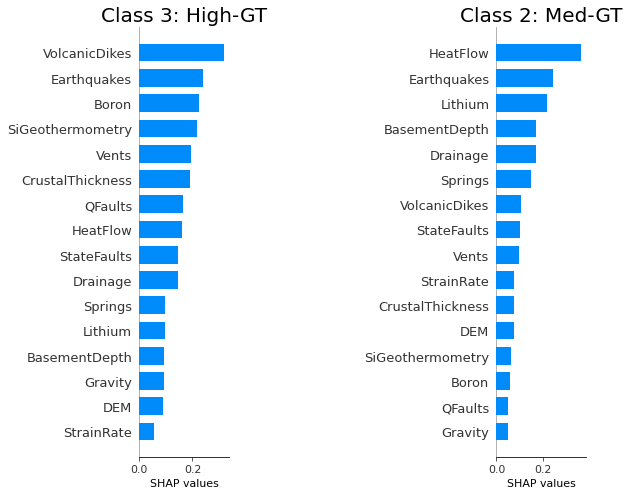

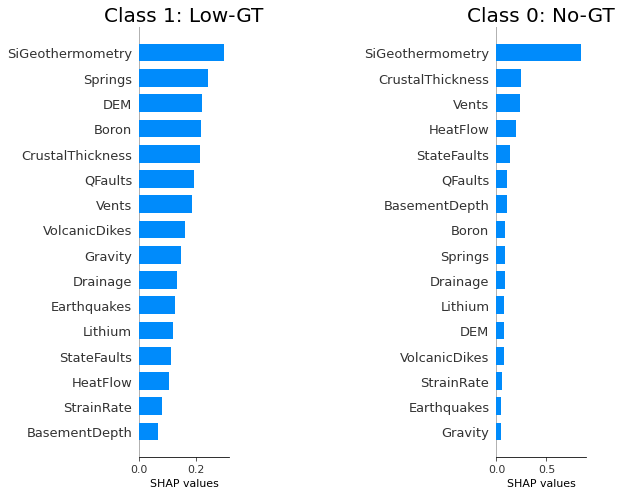

In [137]:
fig = plt.figure(figsize=(30,10))

ax0 = fig.add_subplot(121)
ax0.title.set_text('Class 3: High-GT')
shap.summary_plot(shap_values[3], Xtssc[fs_keepcols], plot_type="bar", show=False)
ax0.set_xlabel(r'SHAP values', fontsize=11)
plt.subplots_adjust(wspace = 3)

ax1 = fig.add_subplot(122)
ax1.title.set_text('Class 2: Med-GT')
shap.summary_plot(shap_values[2], Xtssc[fs_keepcols], plot_type="bar", show=False)
ax1.set_xlabel(r'SHAP values', fontsize=11)
#plt.savefig(datafolder / 'xgb16_shapley_classplots1.png')

fig = plt.figure(figsize=(30,10))

ax2 = fig.add_subplot(121)
ax2.title.set_text('Class 1: Low-GT')
shap.summary_plot(shap_values[1], Xtssc[fs_keepcols], plot_type="bar", show=False)
ax2.set_xlabel(r'SHAP values', fontsize=11)
plt.subplots_adjust(wspace = 3)

ax3 = fig.add_subplot(122)
ax3.title.set_text('Class 0: No-GT')
shap.summary_plot(shap_values[0], Xtssc[fs_keepcols], plot_type="bar", show=False)
ax3.set_xlabel(r'SHAP values', fontsize=11)

#plt.savefig(datafolder / 'xgb16_shapley_classplots2.png')
plt.show()

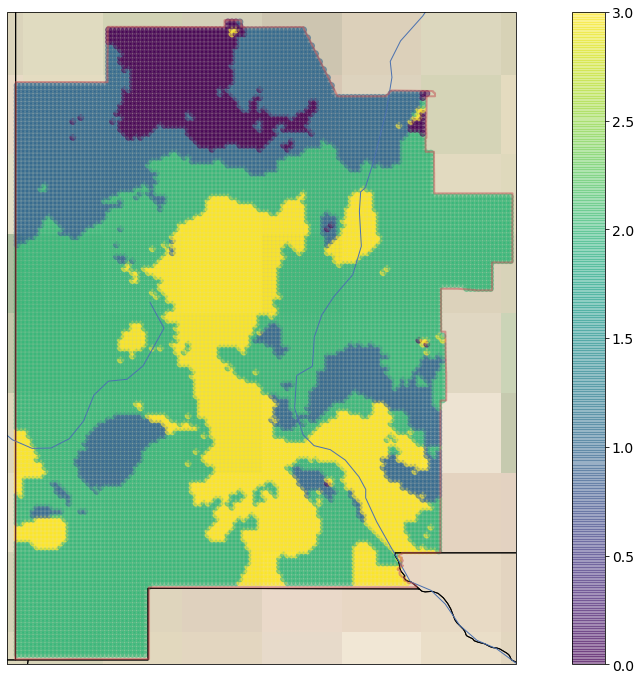

In [138]:
xgb_model_fin16 = XGBClassifier(learning_rate=best_params['learning_rate'],
                                n_estimators=best_params['n_estimators'],
                                max_depth=best_params['max_depth'], 
                                min_child_weight=best_params['min_child_weight'],
                                gamma=best_params['gamma'], 
                                subsample=best_params['subsample'], 
                                colsample_bytree=best_params['colsample_bytree'],
                                reg_lambda=best_params['reg_lambda'],
                                scale_pos_weight=best_params['scale_pos_weight'],
                                objective='multi:softprob',
                                n_jobs=-1,
                                seed=seed)
xgb_model_fin16 = xgb_model_fin.fit(Xallsc[fs_keepcols], yenc_all)

# predict result
FULL_ypred16 = xgb_model_fin16.predict(FULLdfsc[fs_keepcols])
FULL_ypred_proba16 = xgb_model_fin16.predict_proba(FULLdfsc[fs_keepcols])

# plot result
ax = createBasemap();
gdf = gpd.GeoDataFrame(FULLcoords, 
                       geometry=gpd.points_from_xy(FULLcoords.Longitude, FULLcoords.Latitude),
                       crs = {'init': 'epsg:4326'})
pc = ax.scatter(FULLcoords.Longitude,
                FULLcoords.Latitude,
                cmap='viridis',
                c=FULL_ypred16,
                alpha=0.5,
                transform=myprojection);
plt.colorbar(pc);
#plt.savefig(datafolder / 'xgboost16_model_prediction_map.png')
#plt.savefig(datafolder / 'xgboost16_model_prediction_map.pdf')

## Save out final XGB model

In [ ]:
outname = datafolder / 'xgb_model_fin_16feat.json'
#xgb_model_fin16.save_model(str(outname))

In [ ]:
predprobs_test16 = xgb_model_fin16.predict_proba(Xtssc[fs_keepcols])
preds_test16     = np.argmax(predprobs_test, axis=1)

# save out for use in other scripts
shared = {
          "coords":FULLcoords,
          "model":xgb_model_fin16,
          "full_dataset":FULLdf,
          "selected_columns":fs_keepcols,
          "test_yc_pred":preds_test16,
          "test_yc_pred_proba":predprobs_test16,
          "full_yc_pred":FULL_ypred16,
          "full_yc_pred_proba":FULL_ypred_proba16
         }
#with open(datafolder / "gradient_class_prediction_xgb16.pkl","wb") as handle:
#    pkl.dump(shared, handle, protocol=pkl.HIGHEST_PROTOCOL)
